In [1]:
import sys
sys.path.append('../src/')
from modeling.utils.data import *
from modeling.utils.plotting import *
%load_ext autoreload
%autoreload 2

cpu


In [3]:
freq = 'daily'
months = 'MayJunJulAugSep'
obs_years = '1979-2021'
LAT, LONG = (20.,80.), (-90., 30.)
G = 9.80665

In [4]:
daily = read_nc(READ_PATH + '/ERA-5_{}_Geopotential-500hPa_{}_{}.nc'.format(freq, months, obs_years))
daily

	func:'read_nc' took: 0.2635 sec


<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 241, longitude: 481, time: 6579)
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 -89.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 20.5 20.25 20.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1979-05-01 1979-05-02 ... 2021-09-30
Data variables:
    z          (time, expver, latitude, longitude) float32 ...

In [ ]:
daily = daily.where(np.logical_or(
                    daily['time.month'].isin([6,7,8]),
                    np.logical_or(
                        np.logical_and(daily['time.month'] == 5, daily['time.day'] >= 15),
                        np.logical_and(daily['time.month'] == 9, daily['time.day'] <= 15)
                    )),
                    drop = True)
daily

In [5]:
daily = daily.where(daily['time.month'].isin([6,7,8]), drop = True)

In [6]:
dt = xr.concat([daily.sel(time = slice("2021-07-31"), expver = 1),
                daily.sel(time = slice("2021-08-01", "2021-09-30"), expver = 5)],
                dim = "time")
dt = limit_geography(dt, LAT, LONG)
dt = dt / G

	func:'limit_geography' took: 4.7233 sec


In [7]:
normal_dt = evaluate_normal(dt, domain='local', mode='flat', start_year=1991)
#normal_dt = evaluate_normal(dt, domain ='local', mode ='dynamic', freq = 'm', start_year = 1991)
#normal_dt = evaluate_normal(dt, domain ='local', mode ='dynamic', freq = 'w', start_year = 1991)

	func:'evaluate_normal' took: 1.7264 sec


c:\python36\lib\site-packages\xarray\core\accessor_dt.py:379: FutureWarning:

dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.

c:\python36\lib\site-packages\xarray\core\accessor_dt.py:379: FutureWarning:

dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.

c:\python36\lib\site-packages\xarray\core\accessor_dt.py:379: FutureWarning:

dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.

c:\python36\lib\site-packages\xarray\core\accessor_dt.py:379: FutureWarning:

dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.

c:\python36\lib\site-packages\xarray\core\accessor_dt.py:379: FutureWarning:

dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.

c:\python36\lib\site-packages\xarray\core\accessor_dt.py:379: FutureWarning:

dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().w

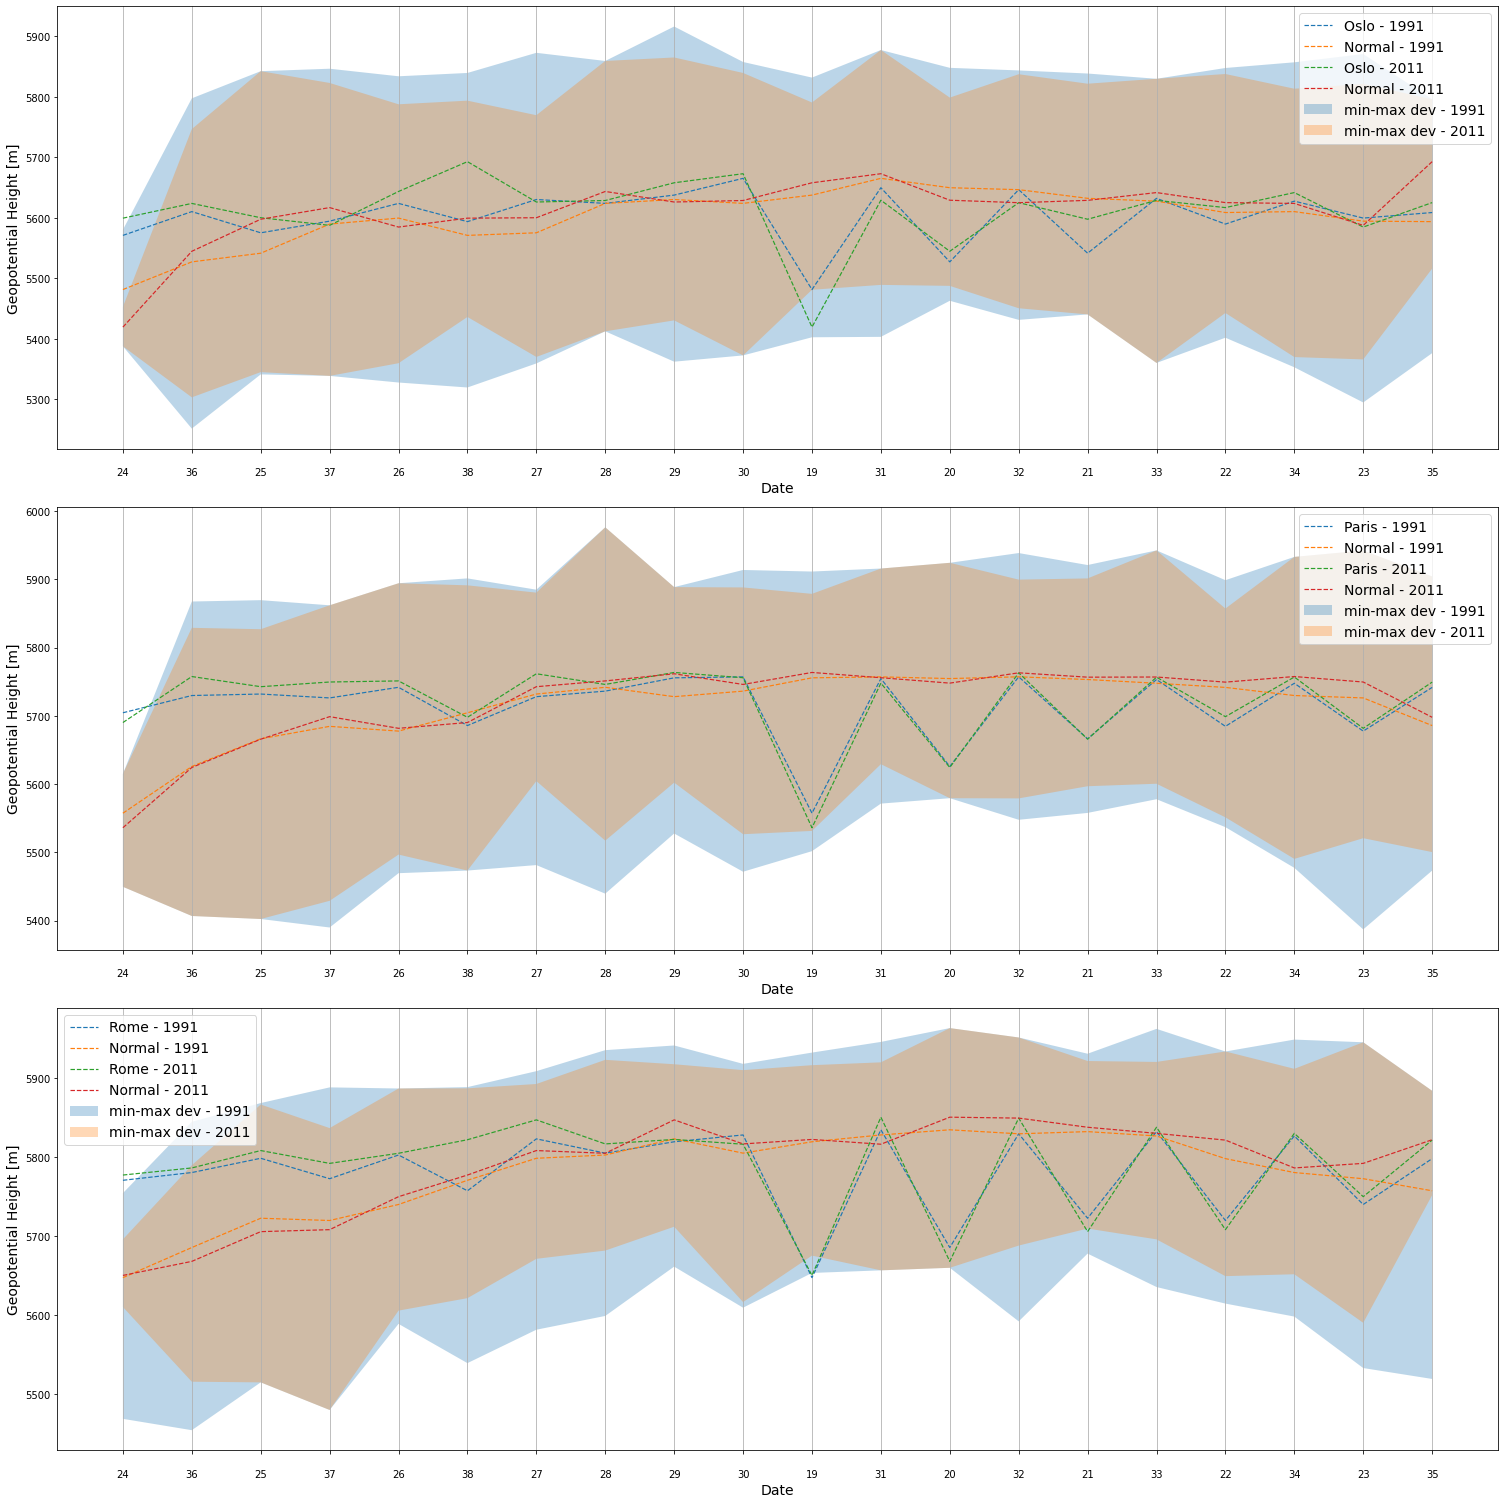

In [17]:
locations = {
    "Oslo":(59.91, 10.76),
    "Paris": (48.86, 2.35),
    "Rome": (41.89, 12.51)
}
plot_normal(dt, locations, freq = 'w')

In [8]:
anomaly_dt = evaluate_anomaly(dt, normal_dt, mode='flat')
#anomaly_dt = evaluate_anomaly(dt, normal_dt, mode='dynamic', freq = 'w')
#to_nc(anomaly_dt, variable='anomaly')

	func:'evaluate_anomaly' took: 0.8826 sec


In [9]:
ds = weighted_anomaly(anomaly_dt)
#to_nc(ds, variable = 'weighted_anomaly')

	func:'weighted_anomaly' took: 2.8105 sec


In [ ]:
for index in np.unique(ds.time.values):
    save_anomalies(ds.sel(time = index),
                   title = "W:/UK/Research/Private/WEATHER/STAGE_ABALDO/imgs/anomalies_img_weighted/anomaly_{}.png".\
                   format(index.astype('M8[D]').astype('O'), "%Y-%m-%d"))

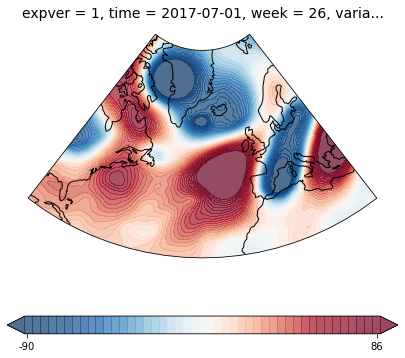

In [11]:
plot_gph(ds.sel(time='2017-07-01').to_array().squeeze())

In [10]:
pivot_anomaly = flat_table(ds)

	func:'flat_table' took: 0.8577 sec


In [13]:
eofs, pcs = eofs(pivot_anomaly)

	func:'eofs' took: 322.4524 sec


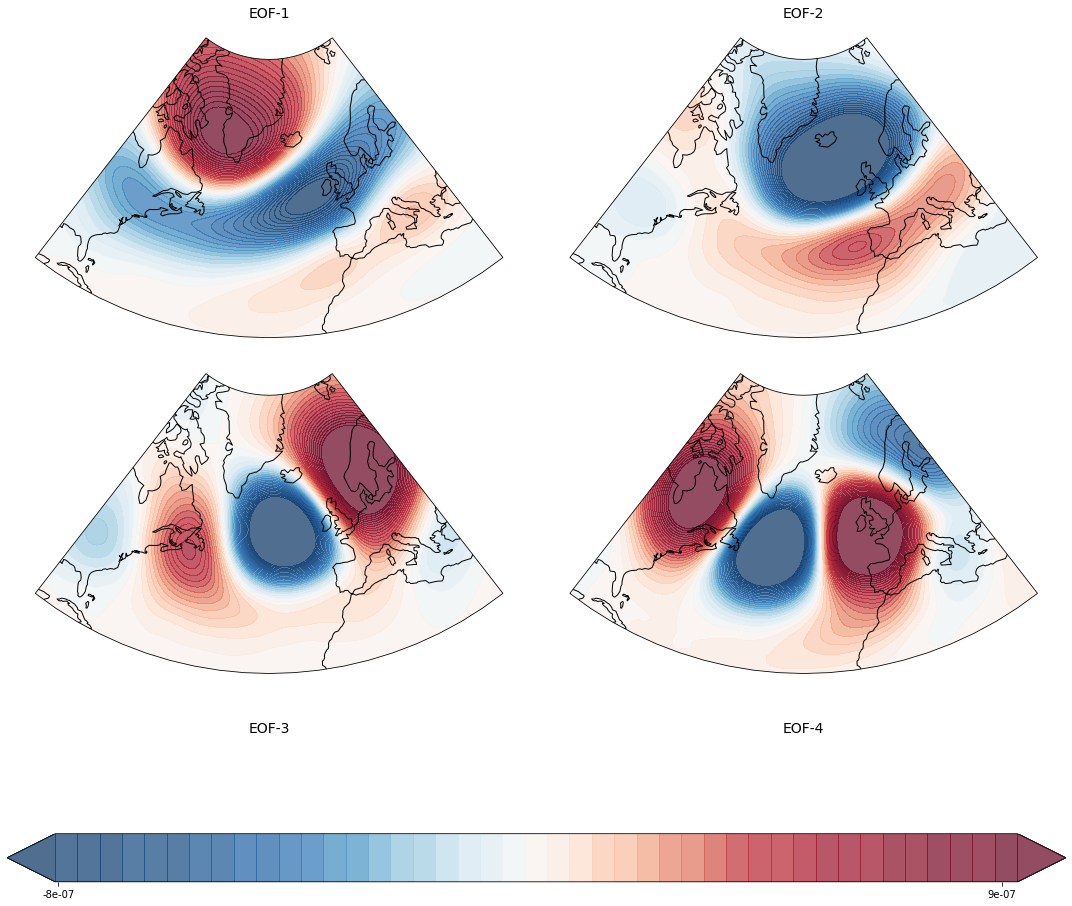

In [14]:
plot_EOFS(eofs)

In [10]:
reduced_anomaly = reduce_dim(pivot_anomaly, method='PCA', exp_variance=0.9)

Number of days: 3956, Density of the grid: 20 cells
	func:'reduce_dim' took: 94.9365 sec


In [11]:
reduced_anomaly = reduce_dim(ds, method='VAE', season = 'SUMMER')

Processing batch 16Number of days: 3956, Density of the grid: 5 cells
	func:'reduce_dim' took: 617.9644 sec


In [ ]:
for model in ['kmeans','bayesian_gmm','gmm']:
    for scoring in  ["score", "ch", "bic", "silhouette"]:
        estimator = cross_val(reduced_anomaly.values, method = model, scoring = scoring, season = "SUMMER")

	Combination 1 score: -751841062.400
	Combination 2 score: -751317132.800
	Combination 3 score: -751715609.600
	Combination 4 score: -752656448.000
	Combination 5 score: -752481382.400
	Combination 6 score: -752481408.000
	Combination 7 score: -752656448.000
	Combination 8 score: -751317145.600
	Combination 9 score: -751715635.200
	Combination 10 score: -752584640.000
	Combination 11 score: -752481395.200
	Combination 12 score: -752481395.200
	Combination 13 score: -752584627.200
	Combination 14 score: -752481395.200
	Combination 15 score: -752481382.400
	Combination 16 score: -752584614.400
	Combination 17 score: -752246208.000
	Combination 18 score: -752481369.600
	Combination 19 score: -752279577.600
	Combination 20 score: -752187776.000
	Combination 21 score: -752476505.600
	Combination 22 score: -752279590.400
	Combination 23 score: -752476505.600
	Combination 24 score: -752476480.000
	Combination 25 score: -752279577.600
	Combination 26 score: -752476505.600
	Combination 27 score

	Combination 78 score: 181.753
	Combination 79 score: 181.473
	Combination 80 score: 181.753
	Combination 81 score: 181.753
	Combination 82 score: 181.635
	Combination 83 score: 181.684
	Combination 84 score: 181.684
	Combination 85 score: 181.637
	Combination 86 score: 181.684
	Combination 87 score: 181.684
	Combination 88 score: 181.635
	Combination 89 score: 181.684
	Combination 90 score: 181.684
	Combination 91 score: 181.946
	Combination 92 score: 181.795
	Combination 93 score: 181.779
	Combination 94 score: 181.946
	Combination 95 score: 181.795
	Combination 96 score: 181.779
	Combination 97 score: 181.946
	Combination 98 score: 181.795
	Combination 99 score: 181.779
	Combination 100 score: 181.681
	Combination 101 score: 181.501
	Combination 102 score: 181.531
	Combination 103 score: 181.681
	Combination 104 score: 181.501
	Combination 105 score: 181.531
	Combination 106 score: 181.681
	Combination 107 score: 181.501
	Combination 108 score: 181.531
	Combination 109 score: 167.69

	Combination 19 score: 0.230
	Combination 20 score: 0.230
	Combination 21 score: 0.230
	Combination 22 score: 0.230
	Combination 23 score: 0.230
	Combination 24 score: 0.230
	Combination 25 score: 0.230
	Combination 26 score: 0.230
	Combination 27 score: 0.230
	Combination 28 score: 0.230
	Combination 29 score: 0.230
	Combination 30 score: 0.230
	Combination 31 score: 0.230
	Combination 32 score: 0.230
	Combination 33 score: 0.230
	Combination 34 score: 0.230
	Combination 35 score: 0.230
	Combination 36 score: 0.230
	Combination 37 score: 0.223
	Combination 38 score: 0.223
	Combination 39 score: 0.223
	Combination 40 score: 0.223
	Combination 41 score: 0.223
	Combination 42 score: 0.223
	Combination 43 score: 0.223
	Combination 44 score: 0.223
	Combination 45 score: 0.223
	Combination 46 score: 0.223
	Combination 47 score: 0.223
	Combination 48 score: 0.223
	Combination 49 score: 0.223
	Combination 50 score: 0.223
	Combination 51 score: 0.223
	Combination 52 score: 0.223
	Combination 5

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 4 score: -37.863


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 5 score: -37.794


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 6 score: -38.192
	Combination 7 score: -38.258


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 8 score: -37.795
	Combination 9 score: -37.884
	Combination 10 score: -38.044
	Combination 11 score: -38.325
	Combination 12 score: -38.319
	Combination 13 score: -38.300
	Combination 14 score: -37.818
	Combination 15 score: -38.163
	Combination 16 score: -38.520
	Combination 17 score: -37.867
	Combination 18 score: -37.803
	Combination 19 score: -38.840
	Combination 20 score: -37.838
	Combination 21 score: -38.039
	Combination 22 score: -37.799


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 23 score: -37.802


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or che

	Combination 24 score: -37.869
	Combination 25 score: -38.072
	Combination 26 score: -38.096
	Combination 27 score: -38.326
	Combination 28 score: -38.297
	Combination 29 score: -37.904
	Combination 30 score: -37.958
	Combination 31 score: -38.324
	Combination 32 score: -38.315


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 33 score: -37.754
	Combination 34 score: -37.994


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 35 score: -37.776
	Combination 36 score: -37.751


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 37 score: -37.776
	Combination 38 score: -308.487


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 39 score: -37.728


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 40 score: -37.791
	Combination 41 score: -37.843
	Combination 42 score: -37.805
	Combination 43 score: -39.207
	Combination 44 score: -38.680
	Combination 45 score: -37.879
	Combination 46 score: -38.148
	Combination 47 score: -38.444
	Combination 48 score: -38.682
	Combination 49 score: -37.789
	Combination 50 score: -37.874
	Combination 51 score: -37.832
	Combination 52 score: -37.968
	Combination 53 score: -38.113
	Combination 54 score: -37.803


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 55 score: -37.930


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 56 score: -37.760
	Combination 57 score: -37.915
	Combination 58 score: -38.399
	Combination 59 score: -38.109
	Combination 60 score: -38.224
	Combination 61 score: -37.918
	Combination 62 score: -38.261
	Combination 63 score: -38.163
	Combination 64 score: -38.509
	Combination 65 score: -37.870
	Combination 66 score: -37.832


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 67 score: -37.940
	Combination 68 score: -38.023
	Combination 69 score: -37.718
	Combination 70 score: -37.748


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 71 score: -37.783


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 72 score: -37.959
	Combination 73 score: nan
	Combination 74 score: nan
	Combination 75 score: nan
	Combination 76 score: nan
	Combination 77 score: nan
	Combination 78 score: nan
	Combination 79 score: -38.320
	Combination 80 score: nan
	Combination 81 score: nan
	Combination 82 score: nan
	Combination 83 score: nan
	Combination 84 score: nan
	Combination 85 score: nan
	Combination 86 score: nan
	Combination 87 score: nan
	Combination 88 score: nan
	Combination 89 score: nan
	Combination 90 score: nan
	Combination 91 score: nan
	Combination 92 score: nan
	Combination 93 score: nan
	Combination 94 score: nan
	Combination 95 score: nan
	Combination 96 score: nan
	Combination 97 score: nan
	Combination 98 score: -38.058
	Combination 99 score: nan
	Combination 100 score: nan
	Combination 101 score: nan
	Combination 102 score: nan
	Combination 103 score: nan


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 104 score: nan
	Combination 105 score: nan
	Combination 106 score: nan
	Combination 107 score: nan
	Combination 108 score: nan
	Combination 109 score: nan
	Combination 110 score: nan
	Combination 111 score: nan
	Combination 112 score: nan
	Combination 113 score: nan
	Combination 114 score: nan
	Combination 115 score: nan
	Combination 116 score: nan
	Combination 117 score: nan
	Combination 118 score: nan
	Combination 119 score: nan


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or che

	Combination 120 score: -37.972
	Combination 121 score: nan
	Combination 122 score: -37.920
	Combination 123 score: -37.908
	Combination 124 score: nan
	Combination 125 score: -37.764
	Combination 126 score: -37.856
	Combination 127 score: -38.144
	Combination 128 score: -38.056
Validation process ended with score -37.71757763279849
Best parameters: {'covariance_prior': None, 'covariance_type': 'full', 'degrees_of_freedom_prior': None, 'init_params': 'random', 'max_iter': 100, 'mean_precision_prior': None, 'mean_prior': None, 'n_components': 6, 'n_init': 5, 'random_state': 42, 'reg_covar': 1e-06, 'tol': 0.001, 'verbose': 0, 'verbose_interval': 10, 'warm_start': False, 'weight_concentration_prior': None, 'weight_concentration_prior_type': 'dirichlet_process'}
	func:'cross_val' took: 5235.7708 sec
	Combination 1 score: 143.351
	Combination 2 score: 147.937


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 3 score: 141.684


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 4 score: 146.630
	Combination 5 score: 146.228
	Combination 6 score: 168.480
	Combination 7 score: 182.151


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 8 score: 143.824
	Combination 9 score: 159.598
	Combination 10 score: nan
	Combination 11 score: nan
	Combination 12 score: nan
	Combination 13 score: nan
	Combination 14 score: 146.439
	Combination 15 score: nan
	Combination 16 score: nan
	Combination 17 score: nan
	Combination 18 score: 153.239
	Combination 19 score: 155.019
	Combination 20 score: nan
	Combination 21 score: nan
	Combination 22 score: 148.349
	Combination 23 score: nan
	Combination 24 score: nan
	Combination 25 score: nan
	Combination 26 score: nan
	Combination 27 score: 132.946
	Combination 28 score: nan
	Combination 29 score: nan
	Combination 30 score: 187.784
	Combination 31 score: nan
	Combination 32 score: nan
	Combination 33 score: 124.128


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 34 score: 99.240


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 35 score: 124.808


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 36 score: 118.434
	Combination 37 score: 118.322


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 38 score: 132.656


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 39 score: 126.421


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 40 score: 125.638
	Combination 41 score: 144.328
	Combination 42 score: 137.845
	Combination 43 score: nan
	Combination 44 score: nan
	Combination 45 score: 131.460
	Combination 46 score: 166.960
	Combination 47 score: nan
	Combination 48 score: 126.767
	Combination 49 score: 120.607
	Combination 50 score: 158.232
	Combination 51 score: 123.541


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or che

	Combination 52 score: 97.684
	Combination 53 score: 114.184
	Combination 54 score: 120.372
	Combination 55 score: 119.785


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or che

	Combination 56 score: 120.425
	Combination 57 score: 160.776
	Combination 58 score: 165.572
	Combination 59 score: 161.605
	Combination 60 score: nan
	Combination 61 score: nan
	Combination 62 score: 119.153
	Combination 63 score: nan
	Combination 64 score: 116.133
	Combination 65 score: 110.300


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 66 score: 108.215


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 67 score: nan


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 68 score: 129.514


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 69 score: 126.462
	Combination 70 score: 88.234


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 71 score: 117.347
	Combination 72 score: 104.063
	Combination 73 score: 153.296
	Combination 74 score: nan
	Combination 75 score: nan
	Combination 76 score: nan
	Combination 77 score: 154.581
	Combination 78 score: 124.021
	Combination 79 score: nan
	Combination 80 score: nan
	Combination 81 score: 119.972
	Combination 82 score: 103.705


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or che

	Combination 83 score: 112.398
	Combination 84 score: nan
	Combination 85 score: 147.240
	Combination 86 score: 98.838


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 87 score: 109.787


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or che

	Combination 88 score: 109.247
	Combination 89 score: nan
	Combination 90 score: nan
	Combination 91 score: nan
	Combination 92 score: nan
	Combination 93 score: 98.618
	Combination 94 score: 105.828
	Combination 95 score: nan
	Combination 96 score: 98.136
	Combination 97 score: nan
	Combination 98 score: 148.427


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 99 score: 105.309


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 100 score: 114.888
	Combination 101 score: 109.477
	Combination 102 score: 112.331


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 103 score: 119.710


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 104 score: 91.318
	Combination 105 score: nan
	Combination 106 score: nan
	Combination 107 score: nan
	Combination 108 score: nan
	Combination 109 score: 110.411
	Combination 110 score: nan
	Combination 111 score: 170.775
	Combination 112 score: nan
	Combination 113 score: nan
	Combination 114 score: 153.479
	Combination 115 score: 107.480
	Combination 116 score: nan


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 117 score: 107.524
	Combination 118 score: 100.563
	Combination 119 score: 81.615
	Combination 120 score: 122.252
	Combination 121 score: nan
	Combination 122 score: nan
	Combination 123 score: 117.010
	Combination 124 score: nan
	Combination 125 score: nan
	Combination 126 score: 175.036
	Combination 127 score: nan
	Combination 128 score: nan
Validation process ended with score 187.78384324308968
Best parameters: {'covariance_prior': None, 'covariance_type': 'full', 'degrees_of_freedom_prior': None, 'init_params': 'random', 'max_iter': 3000, 'mean_precision_prior': None, 'mean_prior': None, 'n_components': 4, 'n_init': 10, 'random_state': 42, 'reg_covar': 1e-06, 'tol': 0.001, 'verbose': 0, 'verbose_interval': 10, 'warm_start': False, 'weight_concentration_prior': None, 'weight_concentration_prior_type': 'dirichlet_distribution'}
	func:'cross_val' took: 7155.6343 sec
	Combination 1 score: -31130.507
	Combination 2 score: -31043.604
	Combination 3 score: -31194.424


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 4 score: -31115.521
	Combination 5 score: -31117.848
	Combination 6 score: -31451.914
	Combination 7 score: -31949.392
	Combination 8 score: -31067.244
	Combination 9 score: -31633.877
	Combination 10 score: -31425.656
	Combination 11 score: -30902.233
	Combination 12 score: -30960.110
	Combination 13 score: -31055.057
	Combination 14 score: -31338.524
	Combination 15 score: -30966.221
	Combination 16 score: -30948.692
	Combination 17 score: -31135.217
	Combination 18 score: -31175.442
	Combination 19 score: -31443.136
	Combination 20 score: -31444.216
	Combination 21 score: -31143.698
	Combination 22 score: -31132.209


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 23 score: -31455.407
	Combination 24 score: -31789.695
	Combination 25 score: -31050.588
	Combination 26 score: -31182.646
	Combination 27 score: -31255.288
	Combination 28 score: -30981.733
	Combination 29 score: -30968.892
	Combination 30 score: -31098.826
	Combination 31 score: -31014.265
	Combination 32 score: -31053.602
	Combination 33 score: -31205.325
	Combination 34 score: -31233.729
	Combination 35 score: -31033.159


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 36 score: -31172.631
	Combination 37 score: -31240.959


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 38 score: -31849.989
	Combination 39 score: -31266.280
	Combination 40 score: -31489.666
	Combination 41 score: -31133.210
	Combination 42 score: -31568.178
	Combination 43 score: -31000.288
	Combination 44 score: -31162.899
	Combination 45 score: -31082.921
	Combination 46 score: -30996.025
	Combination 47 score: -31086.206
	Combination 48 score: -31688.573
	Combination 49 score: -31172.387
	Combination 50 score: -31313.419


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 51 score: -31193.468
	Combination 52 score: -31531.758
	Combination 53 score: -31234.100
	Combination 54 score: -31636.398


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 55 score: -31905.102


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or che

	Combination 56 score: -31189.308
	Combination 57 score: -31222.833
	Combination 58 score: -31124.599
	Combination 59 score: -30978.415
	Combination 60 score: -30970.684
	Combination 61 score: -31158.284
	Combination 62 score: -31133.486
	Combination 63 score: -31008.022
	Combination 64 score: -30947.117
	Combination 65 score: -31274.170
	Combination 66 score: -31890.970


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 67 score: -31150.522


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 68 score: nan


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 69 score: -31303.337
	Combination 70 score: -31264.927


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 71 score: -31575.278


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 72 score: -31314.195
	Combination 73 score: -31166.751
	Combination 74 score: nan
	Combination 75 score: -30999.681
	Combination 76 score: -31214.352
	Combination 77 score: -31215.010
	Combination 78 score: -31309.266
	Combination 79 score: -31142.388
	Combination 80 score: -30943.669
	Combination 81 score: -31618.975
	Combination 82 score: -31216.921
	Combination 83 score: nan


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 84 score: nan
	Combination 85 score: -31483.287
	Combination 86 score: -31811.362


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 87 score: -31580.222
	Combination 88 score: -31118.294
	Combination 89 score: -31286.658
	Combination 90 score: -31179.696
	Combination 91 score: nan
	Combination 92 score: -31104.888
	Combination 93 score: -31505.178
	Combination 94 score: -31235.511
	Combination 95 score: -31060.637
	Combination 96 score: -31052.455
	Combination 97 score: -31475.397


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 98 score: -31250.044


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 99 score: -31605.668


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 100 score: -31710.743
	Combination 101 score: -31465.148


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 102 score: -31192.469


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 103 score: -31333.901


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 104 score: -31325.556
	Combination 105 score: -31282.421
	Combination 106 score: -31240.069
	Combination 107 score: -31696.899
	Combination 108 score: nan
	Combination 109 score: -31212.031
	Combination 110 score: -31267.614
	Combination 111 score: nan
	Combination 112 score: -31216.026
	Combination 113 score: nan
	Combination 114 score: nan
	Combination 115 score: -31547.474
	Combination 116 score: -31739.329
	Combination 117 score: -31612.985
	Combination 118 score: -31832.010


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 119 score: -31690.664


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 120 score: nan
	Combination 121 score: -31243.573
	Combination 122 score: nan
	Combination 123 score: nan
	Combination 124 score: -31030.686
	Combination 125 score: nan
	Combination 126 score: -31349.836
	Combination 127 score: nan
	Combination 128 score: nan
Validation process ended with score -30902.232848674892
Best parameters: {'covariance_prior': None, 'covariance_type': 'full', 'degrees_of_freedom_prior': None, 'init_params': 'kmeans', 'max_iter': 3000, 'mean_precision_prior': None, 'mean_prior': None, 'n_components': 4, 'n_init': 5, 'random_state': 42, 'reg_covar': 1e-06, 'tol': 1e-07, 'verbose': 0, 'verbose_interval': 10, 'warm_start': False, 'weight_concentration_prior': None, 'weight_concentration_prior_type': 'dirichlet_process'}
	func:'cross_val' took: 7770.7361 sec
	Combination 1 score: 0.099
	Combination 2 score: nan


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 3 score: 0.068


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 4 score: 0.052
	Combination 5 score: 0.066
	Combination 6 score: 0.059


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 7 score: 0.043
	Combination 8 score: 0.083
	Combination 9 score: nan
	Combination 10 score: 0.114
	Combination 11 score: nan
	Combination 12 score: nan
	Combination 13 score: 0.108
	Combination 14 score: 0.086
	Combination 15 score: 0.076
	Combination 16 score: nan
	Combination 17 score: 0.057
	Combination 18 score: 0.069
	Combination 19 score: 0.112
	Combination 20 score: 0.111
	Combination 21 score: nan
	Combination 22 score: 0.178


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 23 score: 0.083
	Combination 24 score: 0.081
	Combination 25 score: 0.058
	Combination 26 score: 0.073
	Combination 27 score: 0.348
	Combination 28 score: nan
	Combination 29 score: nan
	Combination 30 score: nan
	Combination 31 score: 0.169
	Combination 32 score: nan
	Combination 33 score: 0.038
	Combination 34 score: 0.063


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 35 score: 0.057


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check fo

	Combination 36 score: 0.089


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 37 score: 0.084
	Combination 38 score: 0.052


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 39 score: 0.057


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 40 score: 0.052
	Combination 41 score: 0.064
	Combination 42 score: 0.071
	Combination 43 score: nan
	Combination 44 score: nan
	Combination 45 score: 0.153
	Combination 46 score: nan
	Combination 47 score: 0.084
	Combination 48 score: nan
	Combination 49 score: 0.062
	Combination 50 score: nan
	Combination 51 score: 0.028
	Combination 52 score: nan
	Combination 53 score: 0.037
	Combination 54 score: 0.162
	Combination 55 score: nan


c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



	Combination 56 score: 0.073
	Combination 57 score: 0.065
	Combination 58 score: nan
	Combination 59 score: nan
	Combination 60 score: nan


In [ ]:
train_X, test_X = train_test_split(reduced_anomaly, test_size = .2)

### PCA: 5 Months

In [17]:
pd.DataFrame.from_dict({model:performance_matrix('../models/SUMMER/pca/'+ model, train_X.values, test_X.values)\
                        for model in os.listdir('../models/SUMMER/pca') if model.endswith('pkl')},
             orient='index')

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



Number of Clusters            BIC  \
bayesian_gmm_model_bic.pkl                          4 -259128.985683   
bayesian_gmm_model_ch.pkl                           6 -259255.169221   
bayesian_gmm_model_score.pkl                        6 -259294.402323   
bayesian_gmm_model_silhouette.pkl                   7 -259300.191829   
gmm_model_bic.pkl                                   4 -259118.394001   
gmm_model_ch.pkl                                    4 -259096.763263   
gmm_model_score.pkl                                 7 -259101.011549   
gmm_model_silhouette.pkl                            4 -259084.455533   
kmeans_model_bic.pkl                                7 -257295.638267   
kmeans_model_ch.pkl                                 4 -257436.075058   
kmeans_model_score.pkl                              7 -257312.038437   
kmeans_model_silhouette.pkl                         4 -257436.075034   

                                   Silhouette Score  Calinski Harabsz Index  \
bayesian_gmm_model_bic.pkl                -0.042559               24.799182   
bayesian_gmm_model_ch.pkl                  0.005901               29.253906   
bayesian_gmm_model_score.pkl              -0.066333               16.183712   
bayesian_gmm_model_silhouette.pkl         -0.037155               29.797579   
gmm_model_bic.pkl                          0.005702               37.311743   
gmm_model_ch.pkl                           0.001369               39.170801   
gmm_model_score.pkl                        0.001518               38.947120   
gmm_model_silhouette.pkl                   0.001974               39.303032   
kmeans_model_bic.pkl                       0.062160               76.284952   
kmeans_model_ch.pkl                        0.074001              104.123006   
kmeans_model_score.pkl                     0.061622               76.218512   
kmeans_model_silhouette.pkl                0.074001              104.123006   

                                        Inertia  
bayesian_gmm_model_bic.pkl         4.819940e+11  
bayesian_gmm_model_ch.pkl          4.595783e+11  
bayesian_gmm_model_score.pkl       4.797283e+11  
bayesian_gmm_model_silhouette.pkl  4.489431e+11  
gmm_model_bic.pkl                  4.691386e+11  
gmm_model_ch.pkl                   4.671494e+11  
gmm_model_score.pkl                4.673096e+11  
gmm_model_silhouette.pkl           4.669829e+11  
kmeans_model_bic.pkl               3.779100e+11  
kmeans_model_ch.pkl                4.106219e+11  
kmeans_model_score.pkl             3.783683e+11  
kmeans_model_silhouette.pkl        4.106219e+11

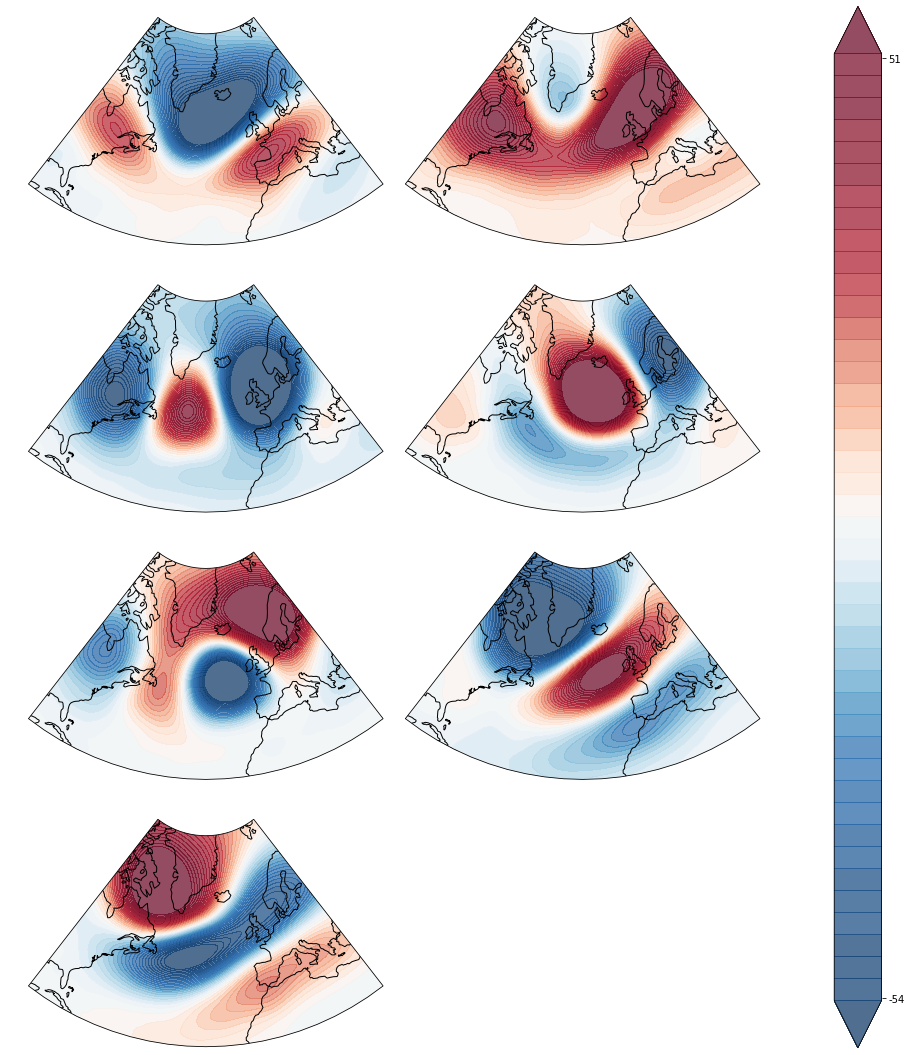

In [13]:
estimator = load_estimator('../models/SUMMER/pca/kmeans_model_bic.pkl')
labels, inertia, _ = extract_regimes(reduced_anomaly, method='kmeans', nb_regimes = 8, estimator = estimator)
plot_regimes(pivot_anomaly, labels)

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



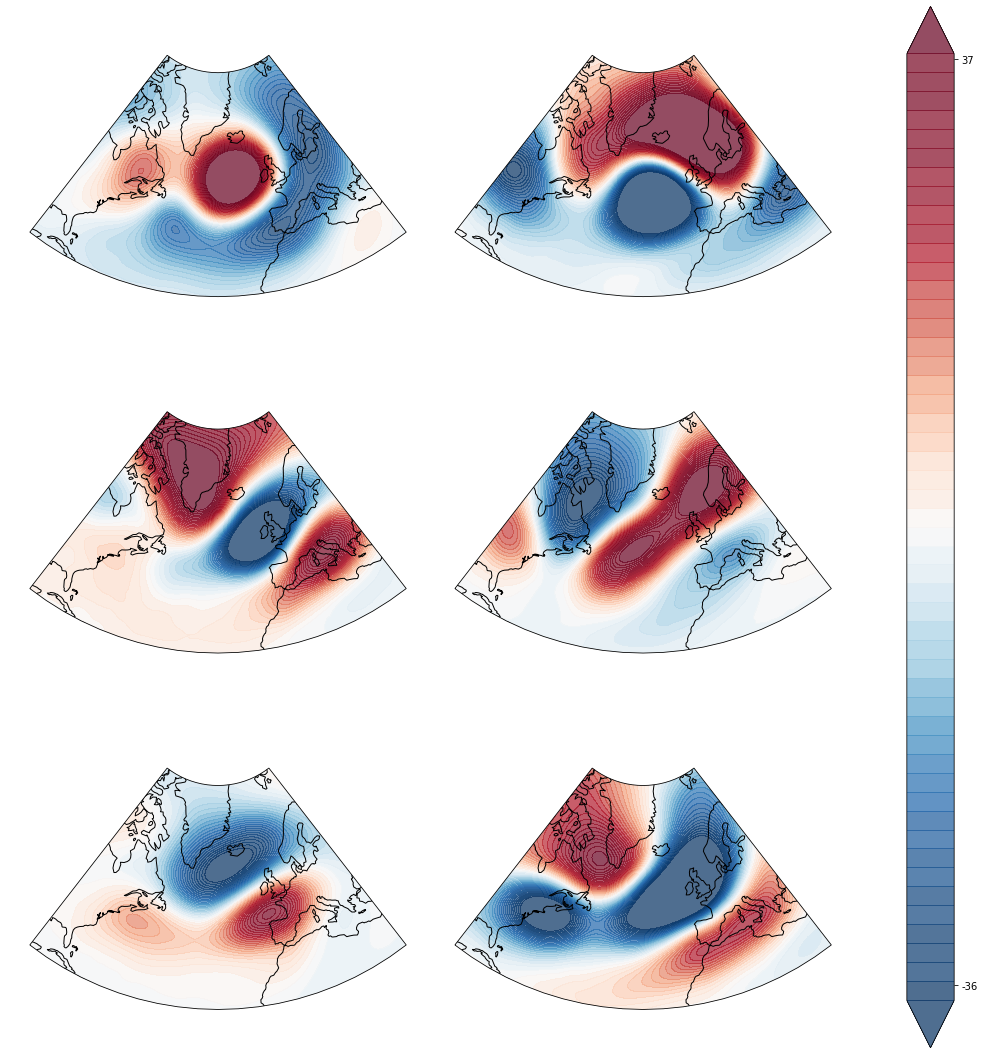

In [14]:
estimator = load_estimator("../models/SUMMER/pca/bayesian_gmm_model_ch.pkl")
probas, elbo, means, covariances, _ = extract_regimes(reduced_anomaly, method='bayesian_gmm', nb_regimes = 6, estimator = estimator)
labels = np.argmax(probas, axis=1)
plot_regimes(pivot_anomaly, labels)

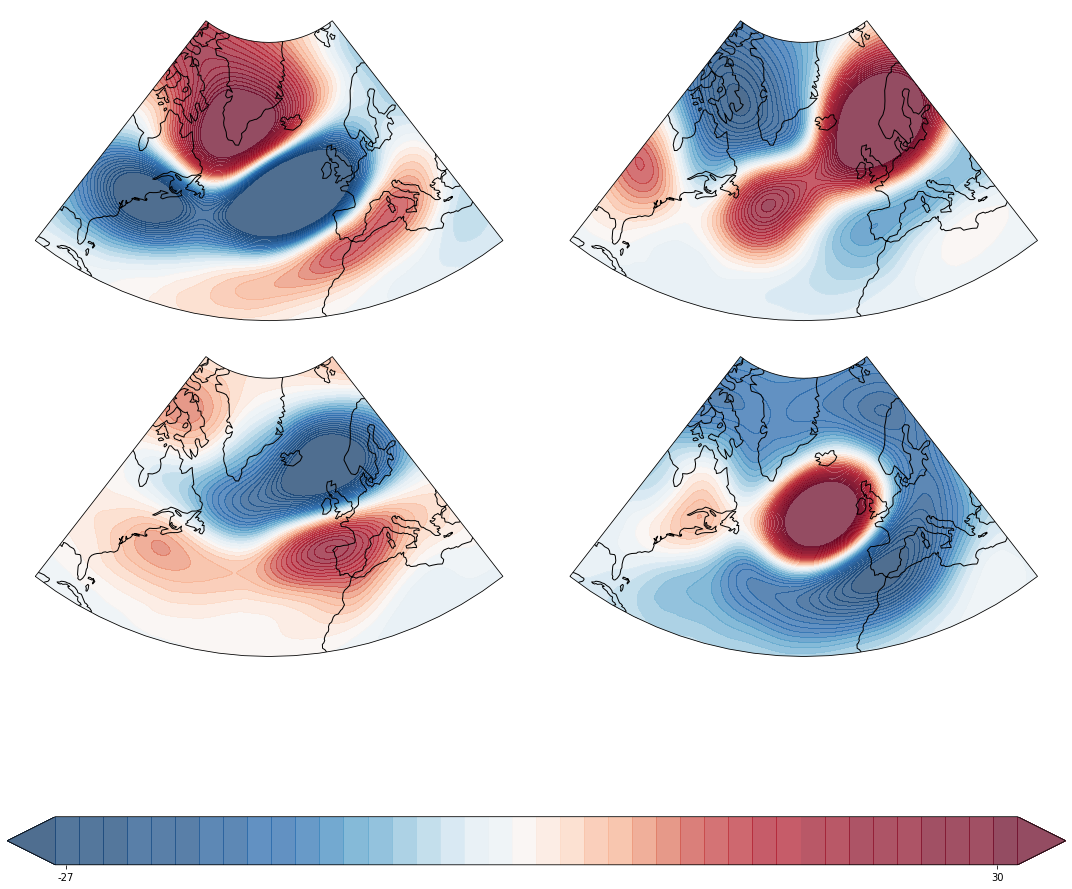

In [21]:
estimator = load_estimator("../models/SUMMER/pca/gmm_model_silhouette.pkl")
probas, elbo, means, covariances, _ = extract_regimes(reduced_anomaly, method='gmm', nb_regimes = 5, estimator = estimator)
labels = np.argmax(probas, axis=1)
plot_regimes(pivot_anomaly, labels)

### VAE: 5 Months

In [14]:
pd.DataFrame.from_dict({model:performance_matrix('../models/SUMMER/vae/'+ model, train_X.values, test_X.values)\
                        for model in os.listdir('../models/SUMMER/vae') if model.endswith('pkl')},
             orient='index')

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check f

Number of Clusters           BIC  \
bayesian_gmm_model_bic.pkl                          4 -43815.929920   
bayesian_gmm_model_ch.pkl                           5 -43921.887772   
bayesian_gmm_model_score.pkl                        7 -44110.652476   
bayesian_gmm_model_silhouette.pkl                   4 -43812.160851   
gmm_model_bic.pkl                                   4 -43818.426627   
gmm_model_ch.pkl                                    4 -43798.241360   
gmm_model_score.pkl                                 5 -43719.576023   
gmm_model_silhouette.pkl                            4 -43809.015604   
kmeans_model_bic.pkl                                7 -43064.104789   
kmeans_model_ch.pkl                                 4 -43073.857413   
kmeans_model_score.pkl                              7 -43069.567711   
kmeans_model_silhouette.pkl                         5 -43054.708500   

                                   Silhouette Score  Calinski Harabsz Index  \
bayesian_gmm_model_bic.pkl                 0.026472               81.840459   
bayesian_gmm_model_ch.pkl                  0.031431               78.649481   
bayesian_gmm_model_score.pkl               0.035359               72.975511   
bayesian_gmm_model_silhouette.pkl          0.027493               81.230524   
gmm_model_bic.pkl                          0.026194               81.368170   
gmm_model_ch.pkl                           0.026456               80.957465   
gmm_model_score.pkl                        0.045948               95.669956   
gmm_model_silhouette.pkl                   0.023767               79.627367   
kmeans_model_bic.pkl                       0.163302              184.140875   
kmeans_model_ch.pkl                        0.167389              209.964522   
kmeans_model_score.pkl                     0.162134              183.613639   
kmeans_model_silhouette.pkl                0.171576              205.848548   

                                        Inertia  
bayesian_gmm_model_bic.pkl         2.370001e+09  
bayesian_gmm_model_ch.pkl          2.252241e+09  
bayesian_gmm_model_score.pkl       2.081303e+09  
bayesian_gmm_model_silhouette.pkl  2.371569e+09  
gmm_model_bic.pkl                  2.372380e+09  
gmm_model_ch.pkl                   2.371222e+09  
gmm_model_score.pkl                2.295145e+09  
gmm_model_silhouette.pkl           2.377958e+09  
kmeans_model_bic.pkl               1.427821e+09  
kmeans_model_ch.pkl                1.828358e+09  
kmeans_model_score.pkl             1.428993e+09  
kmeans_model_silhouette.pkl        1.639344e+09

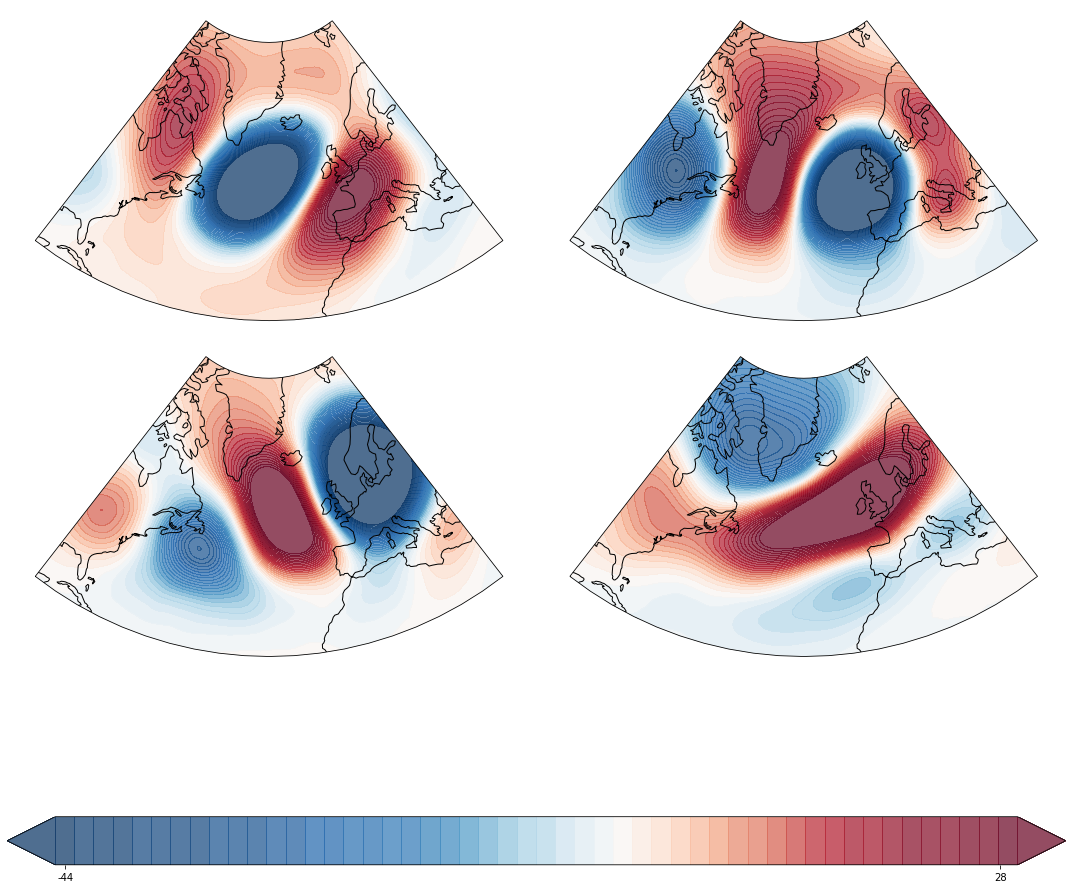

In [15]:
estimator = load_estimator('../models/SUMMER/vae/kmeans_model_ch.pkl')
labels, inertia, _ = extract_regimes(reduced_anomaly, method='kmeans', nb_regimes = 8, estimator = estimator)
plot_regimes(pivot_anomaly, labels)

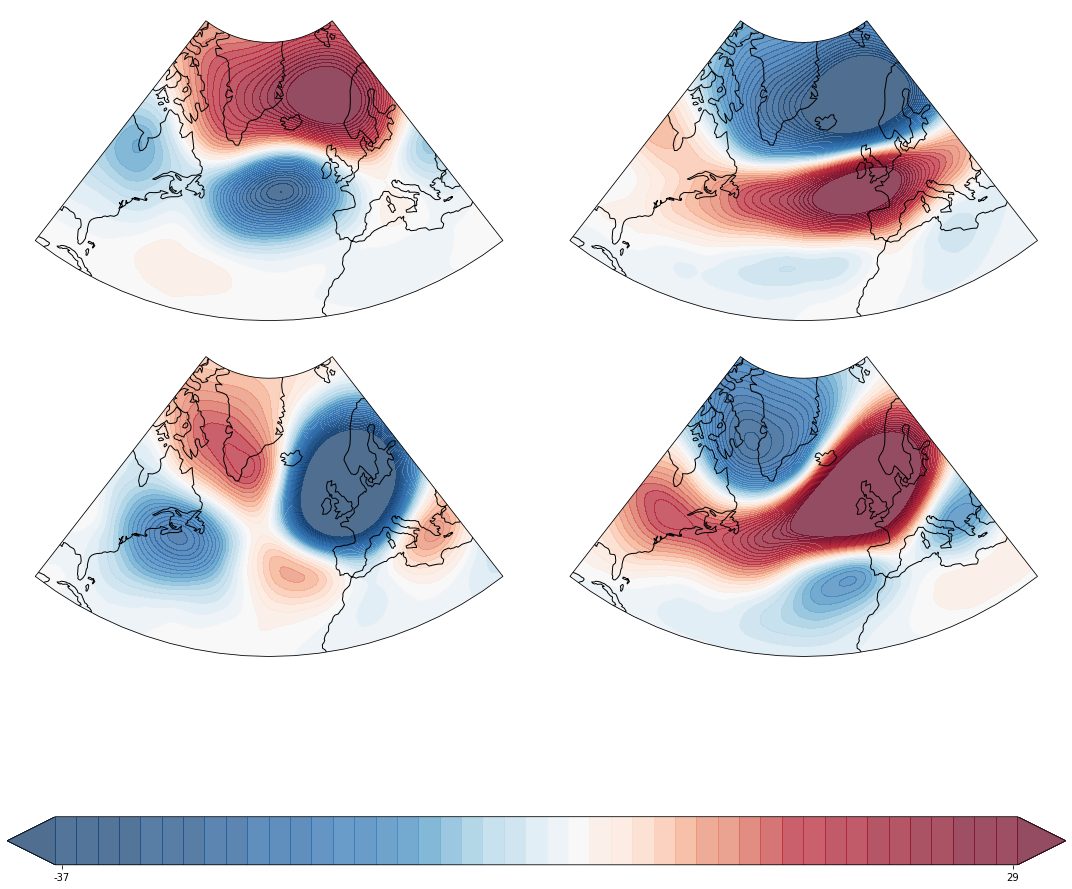

In [16]:
estimator = load_estimator("../models/SUMMER/vae/bayesian_gmm_model_bic.pkl")
probas, elbo, means, covariances, _ = extract_regimes(reduced_anomaly, method='bayesian_gmm', nb_regimes = 6, estimator = estimator)
labels = np.argmax(probas, axis=1)
plot_regimes(pivot_anomaly, labels)

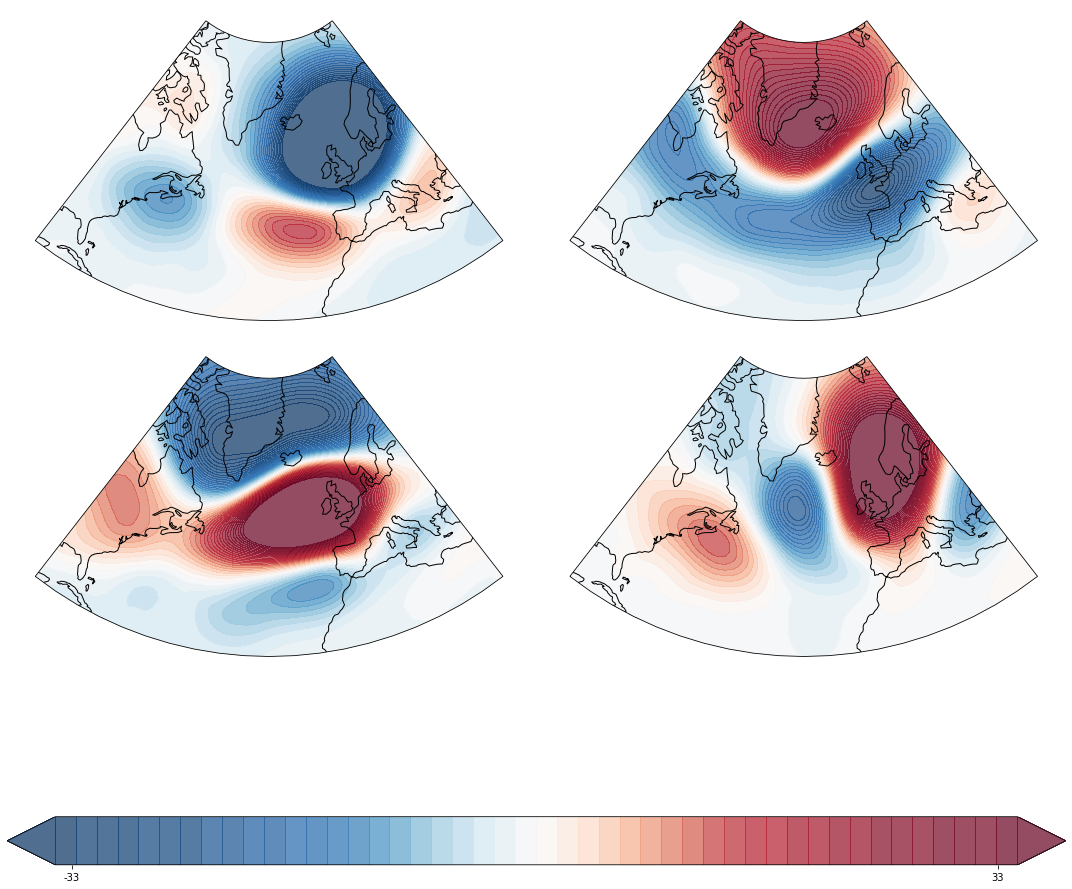

In [17]:
estimator = load_estimator("../models/SUMMER/vae/gmm_model_bic.pkl")
probas, elbo, means, covariances, _ = extract_regimes(reduced_anomaly, method='gmm', nb_regimes = 5, estimator = estimator)
labels = np.argmax(probas, axis=1)
plot_regimes(pivot_anomaly, labels)

### PCA: 4 Months (15th May - 15th Sept) and 4 Normals

In [43]:
pd.DataFrame.from_dict({model:performance_matrix('../models/SUMMER/pca_4months_4normals/'+ model, train_X.values, test_X.values)\
                        for model in os.listdir('../models/SUMMER/pca_4months_4normals') if model.endswith('pkl')},
             orient='index')

Number of Clusters            BIC  \
kmeans_model_bic.pkl                          6 -217531.915663   
kmeans_model_ch.pkl                           4 -217584.918301   
kmeans_model_score.pkl                        7 -217595.562938   
kmeans_model_silhouette.pkl                   4 -217584.918291   

                             Silhouette Score  Calinski Harabsz Index  \
kmeans_model_bic.pkl                 0.067233               69.739260   
kmeans_model_ch.pkl                  0.079402               89.064929   
kmeans_model_score.pkl               0.060097               61.864244   
kmeans_model_silhouette.pkl          0.079402               89.064929   

                                  Inertia  
kmeans_model_bic.pkl         2.876436e+11  
kmeans_model_ch.pkl          3.044836e+11  
kmeans_model_score.pkl       2.830735e+11  
kmeans_model_silhouette.pkl  3.044836e+11

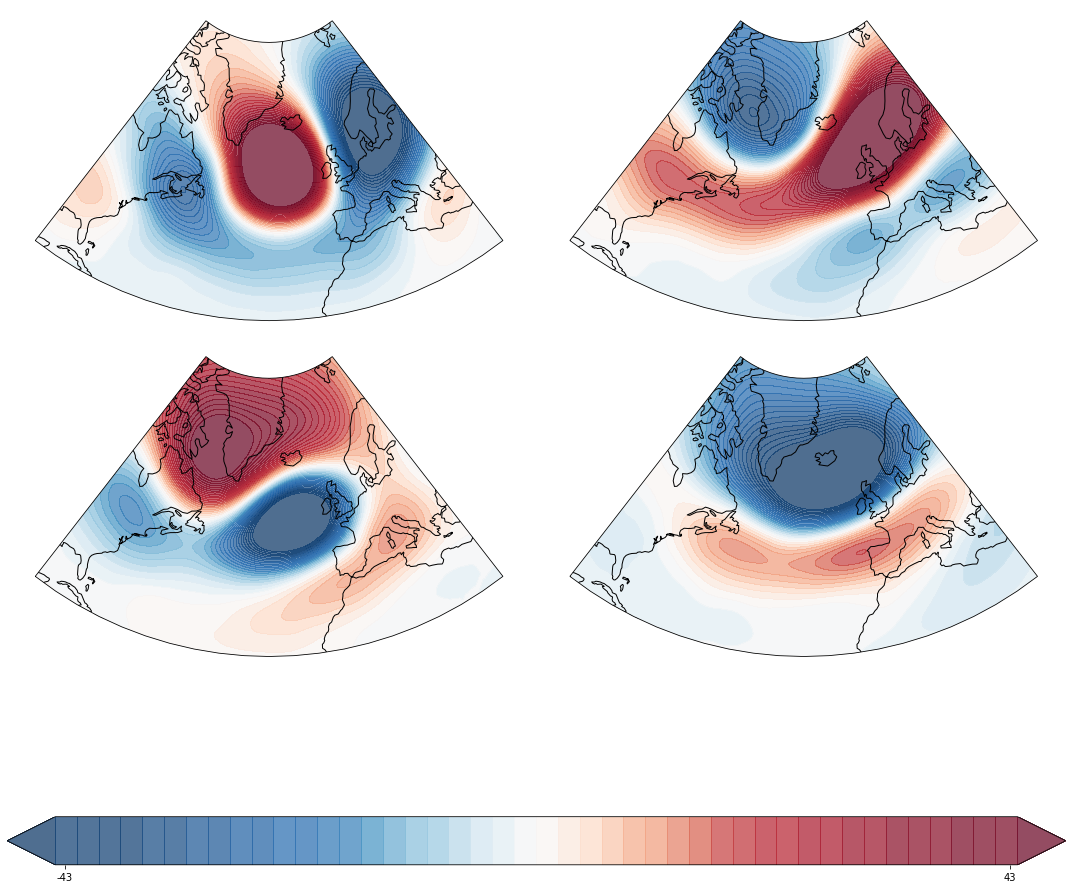

In [44]:
estimator = load_estimator('../models/SUMMER/pca_4months_4normals/kmeans_model_ch.pkl')
labels, inertia, _ = extract_regimes(reduced_anomaly, method='kmeans', nb_regimes = 8, estimator = estimator)
plot_regimes(pivot_anomaly, labels)

### PCA 4 Months (15th May - 15th Sept) and 1 Normal

In [52]:
pd.DataFrame.from_dict({model:performance_matrix('../models/SUMMER/pca_4months_1normal/'+ model, train_X.values, test_X.values)\
                        for model in os.listdir('../models/SUMMER/pca_4months_1normal') if model.endswith('pkl')},
             orient='index')

Number of Clusters            BIC  \
kmeans_model_bic.pkl                          7 -198504.536556   
kmeans_model_ch.pkl                           4 -198706.669321   
kmeans_model_score.pkl                        7 -198504.979985   
kmeans_model_silhouette.pkl                   5 -198586.838446   

                             Silhouette Score  Calinski Harabsz Index  \
kmeans_model_bic.pkl                 0.075481               93.236957   
kmeans_model_ch.pkl                  0.081910              136.675618   
kmeans_model_score.pkl               0.075454               93.235904   
kmeans_model_silhouette.pkl          0.079221              116.429317   

                                  Inertia  
kmeans_model_bic.pkl         2.962523e+11  
kmeans_model_ch.pkl          3.256731e+11  
kmeans_model_score.pkl       2.962459e+11  
kmeans_model_silhouette.pkl  3.135530e+11

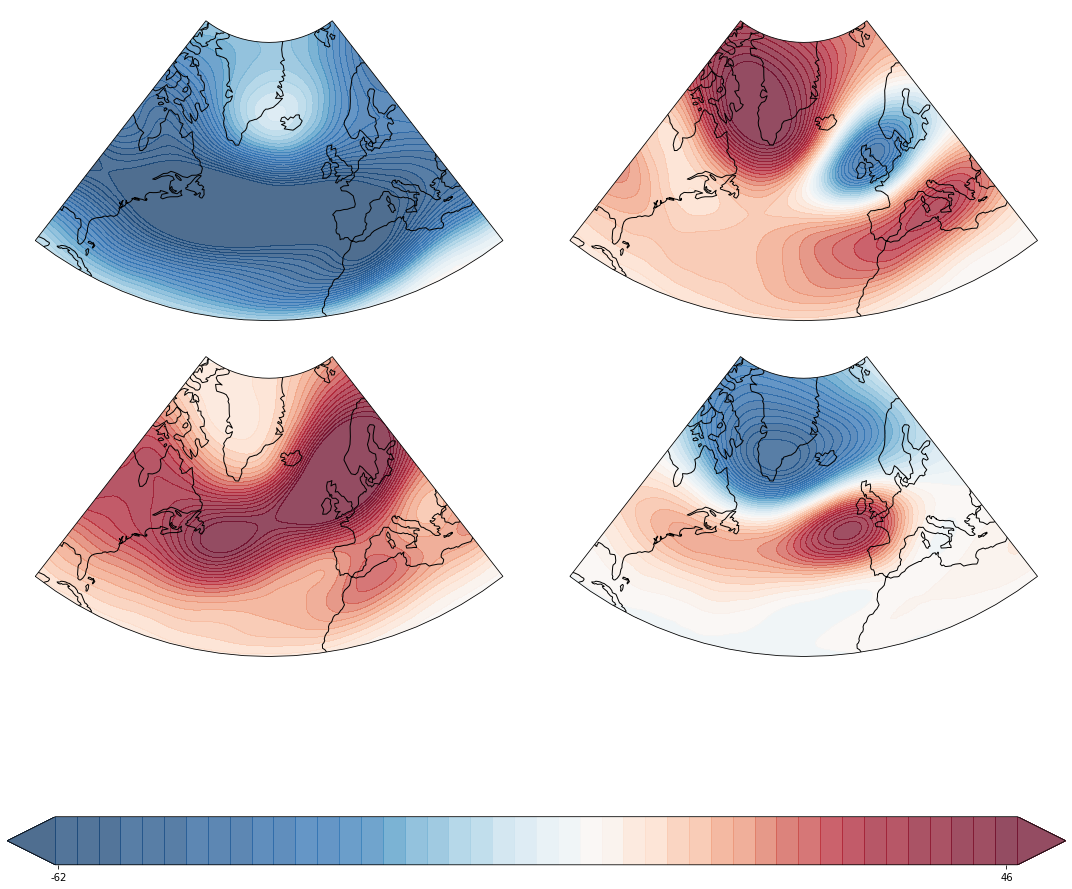

In [53]:
estimator = load_estimator('../models/SUMMER/pca_4months_1normal/kmeans_model_ch.pkl')
labels, inertia, _ = extract_regimes(reduced_anomaly, method='kmeans', nb_regimes = 8, estimator = estimator)
plot_regimes(pivot_anomaly, labels)

### PCA 4 Months (15th May - 15th Sept) and Weekly Normal

In [18]:
pd.DataFrame.from_dict({model:performance_matrix('../models/SUMMER/pca_4months_weeklynormal/'+ model, train_X.values, test_X.values)\
                        for model in os.listdir('../models/SUMMER/pca_4months_weeklynormal') if model.endswith('pkl')},
             orient='index')

Number of Clusters            BIC  \
kmeans_model_bic.pkl                          6 -216646.773611   
kmeans_model_ch.pkl                           4 -216813.570914   
kmeans_model_score.pkl                        7 -216650.550161   
kmeans_model_silhouette.pkl                   4 -216781.365417   

                             Silhouette Score  Calinski Harabsz Index  \
kmeans_model_bic.pkl                 0.068318               71.581387   
kmeans_model_ch.pkl                  0.077449               88.488425   
kmeans_model_score.pkl               0.064913               64.557600   
kmeans_model_silhouette.pkl          0.078479               89.494530   

                                  Inertia  
kmeans_model_bic.pkl         2.658517e+11  
kmeans_model_ch.pkl          2.840987e+11  
kmeans_model_score.pkl       2.603751e+11  
kmeans_model_silhouette.pkl  2.833879e+11

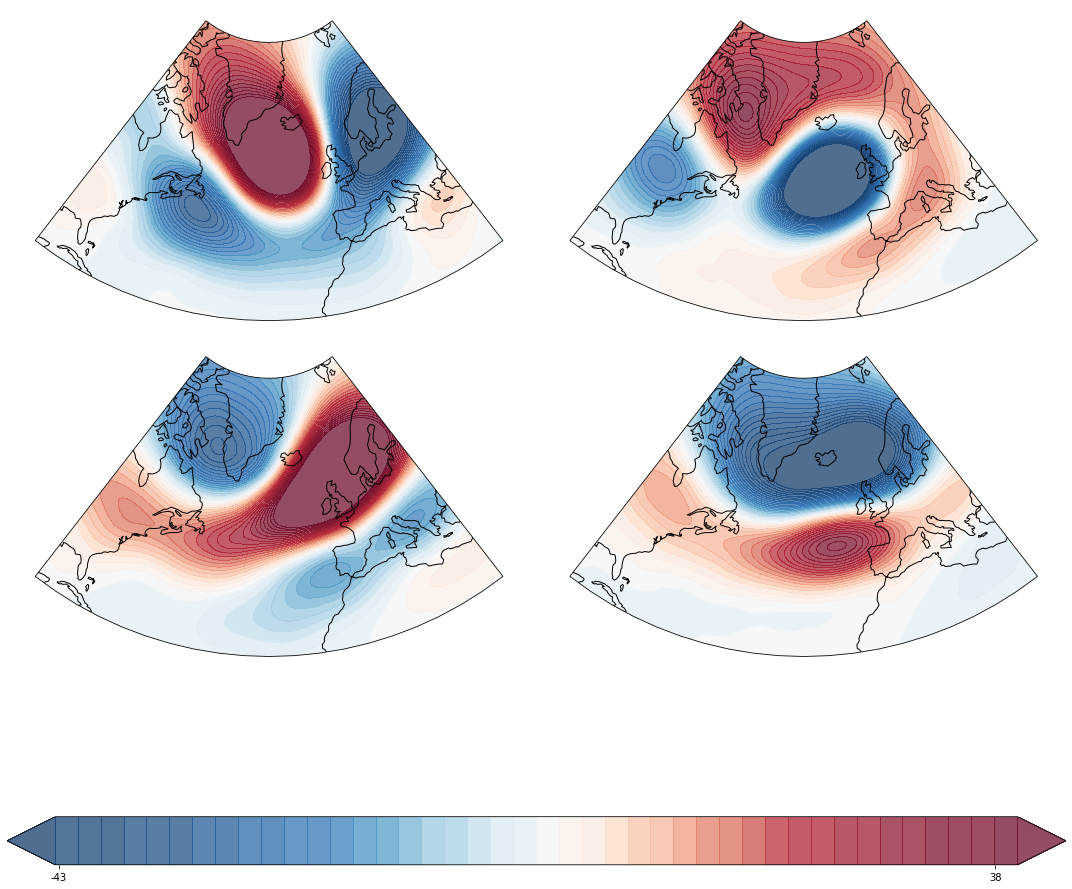

In [20]:
estimator = load_estimator('../models/SUMMER/pca_4months_weeklynormal/kmeans_model_silhouette.pkl')
labels, inertia, _ = extract_regimes(reduced_anomaly, method='kmeans', nb_regimes = 8, estimator = estimator)
plot_regimes(pivot_anomaly, labels)

### VAE: 3 Months (June, July, Aug) and Weekly Normal

In [16]:
pd.DataFrame.from_dict({model:performance_matrix('../models/SUMMER/vae_3months/'+ model, train_X.values, test_X.values)\
                        for model in os.listdir('../models/SUMMER/vae_3months') if model.endswith('pkl')},
             orient='index')

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



Number of Clusters           BIC  \
bayesian_gmm_model_bic.pkl                          4 -32155.848132   
bayesian_gmm_model_ch.pkl                           5 -32172.837942   
bayesian_gmm_model_score.pkl                        7 -32344.511426   
bayesian_gmm_model_silhouette.pkl                   4 -32211.681335   
gmm_model_bic.pkl                                   4 -32236.222260   
gmm_model_ch.pkl                                    4 -32235.253321   
gmm_model_score.pkl                                 5 -32237.988458   
gmm_model_silhouette.pkl                            4 -32148.087526   
kmeans_model_bic.pkl                                5 -31679.093699   
kmeans_model_ch.pkl                                 4 -31698.118109   
kmeans_model_score.pkl                              7 -31742.830541   
kmeans_model_silhouette.pkl                         5 -31684.782327   

                                   Silhouette Score  Calinski Harabsz Index  \
bayesian_gmm_model_bic.pkl                 0.043787               81.178046   
bayesian_gmm_model_ch.pkl                  0.058635               82.666762   
bayesian_gmm_model_score.pkl               0.043449               67.496893   
bayesian_gmm_model_silhouette.pkl          0.042001               70.242106   
gmm_model_bic.pkl                          0.028463               66.163744   
gmm_model_ch.pkl                           0.032263               67.107092   
gmm_model_score.pkl                        0.028153               65.754508   
gmm_model_silhouette.pkl                   0.038685               79.287984   
kmeans_model_bic.pkl                       0.179515              160.655188   
kmeans_model_ch.pkl                        0.173648              168.016343   
kmeans_model_score.pkl                     0.157832              136.801606   
kmeans_model_silhouette.pkl                0.178380              159.809689   

                                        Inertia  
bayesian_gmm_model_bic.pkl         1.447755e+09  
bayesian_gmm_model_ch.pkl          1.330417e+09  
bayesian_gmm_model_score.pkl       1.259868e+09  
bayesian_gmm_model_silhouette.pkl  1.490229e+09  
gmm_model_bic.pkl                  1.509246e+09  
gmm_model_ch.pkl                   1.507760e+09  
gmm_model_score.pkl                1.510540e+09  
gmm_model_silhouette.pkl           1.452286e+09  
kmeans_model_bic.pkl               1.041997e+09  
kmeans_model_ch.pkl                1.151190e+09  
kmeans_model_score.pkl             9.281228e+08  
kmeans_model_silhouette.pkl        1.044452e+09

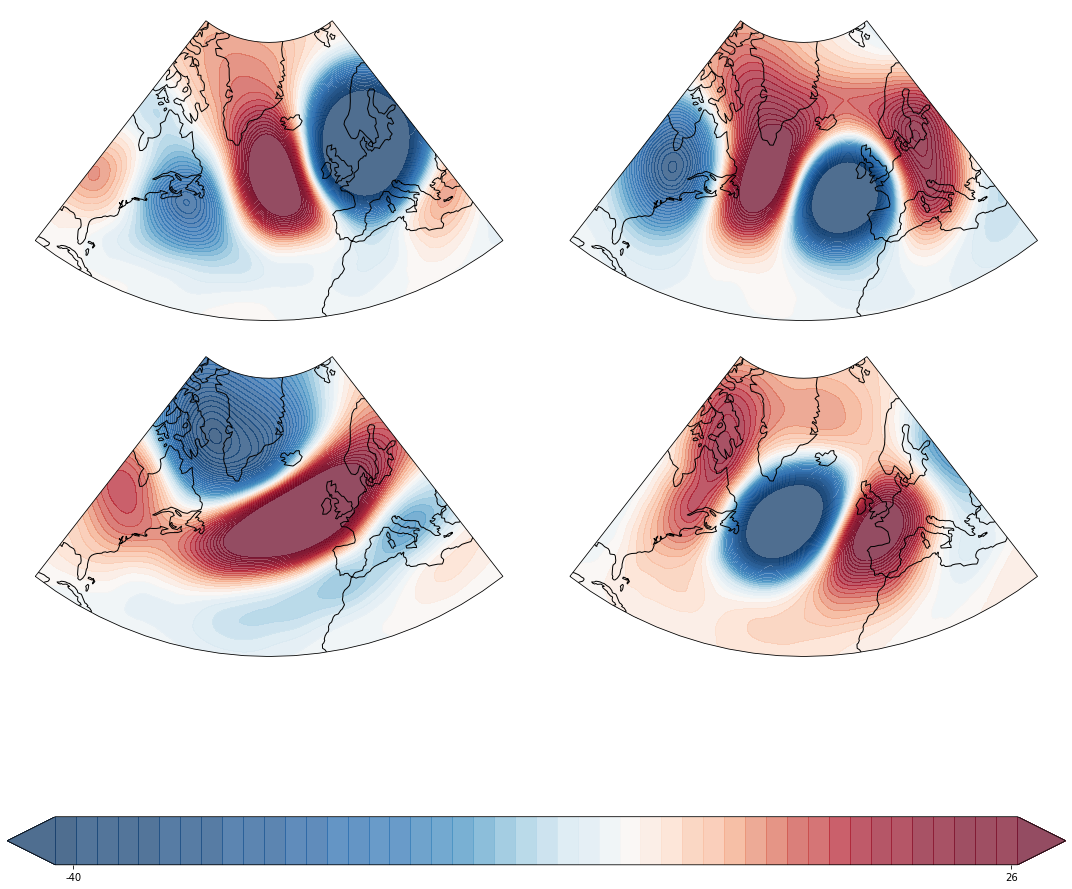

In [18]:
estimator = load_estimator('../models/SUMMER/vae_3months/kmeans_model_ch.pkl')
labels, inertia, _ = extract_regimes(reduced_anomaly, method='kmeans', nb_regimes = 8, estimator = estimator)
plot_regimes(pivot_anomaly, labels)

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



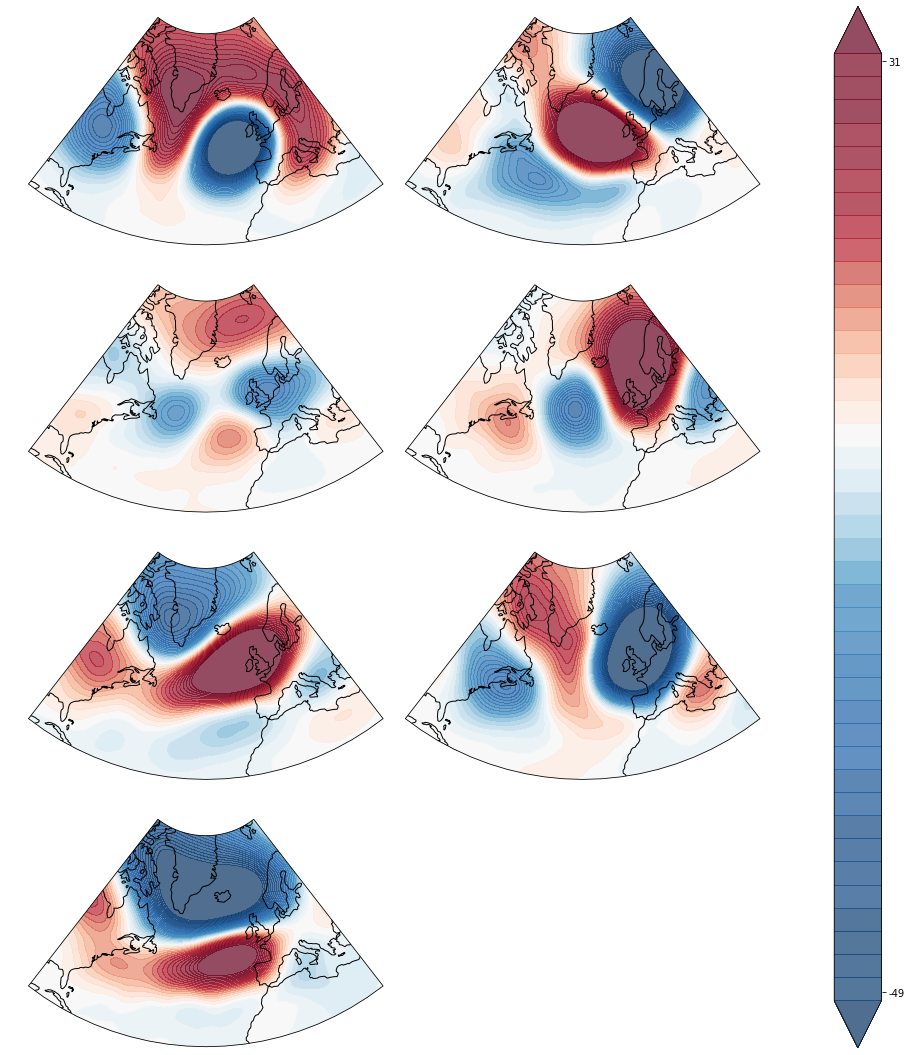

In [26]:
estimator = load_estimator("../models/SUMMER/vae_3months/bayesian_gmm_model_score.pkl")
probas, elbo, means, covariances, _ = extract_regimes(reduced_anomaly, method='gmm', nb_regimes = 5, estimator = estimator)
labels = np.argmax(probas, axis=1)
plot_regimes(pivot_anomaly, labels)

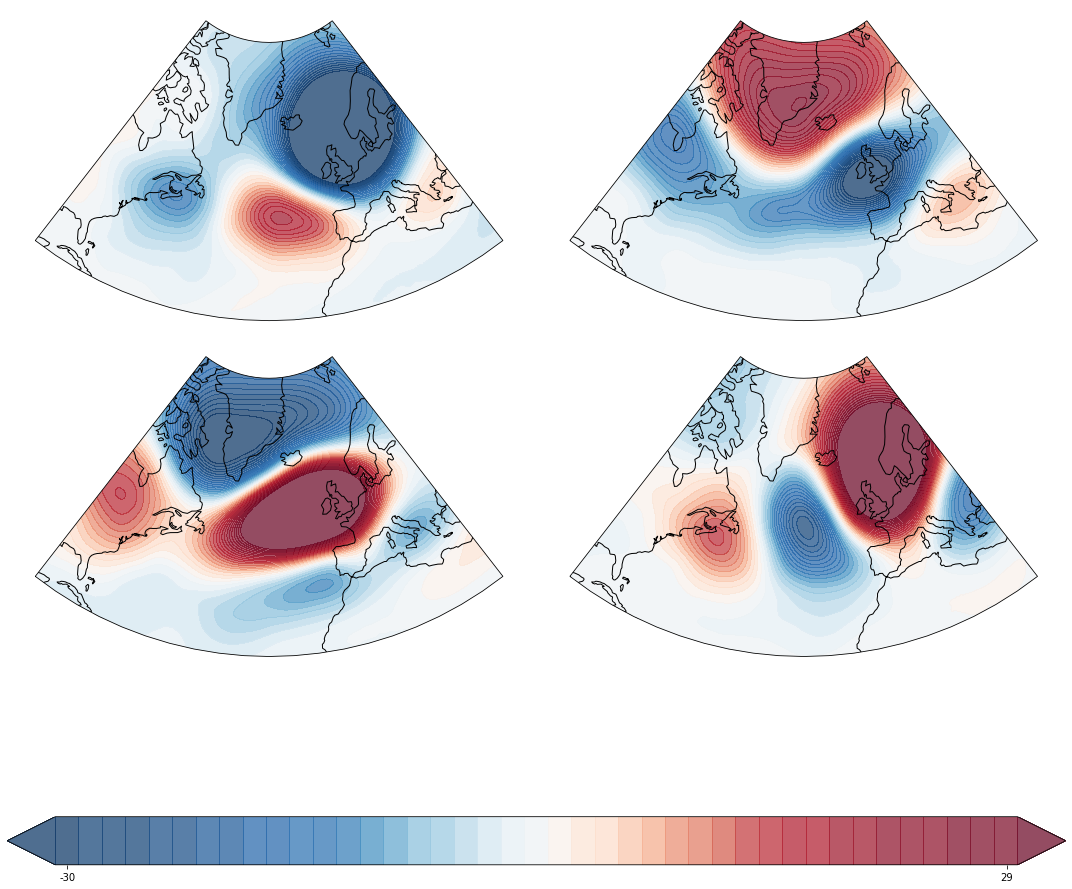

In [20]:
estimator = load_estimator("../models/SUMMER/vae_3months/gmm_model_ch.pkl")
probas, elbo, means, covariances, _ = extract_regimes(reduced_anomaly, method='gmm', nb_regimes = 5, estimator = estimator)
labels = np.argmax(probas, axis=1)
plot_regimes(pivot_anomaly, labels)

### VAE: 3 Months (June, July, Aug) and 1 Normal

In [18]:
pd.DataFrame.from_dict({model:performance_matrix('../models/SUMMER/vae_3months_1normal/'+ model, train_X.values, test_X.values)\
                        for model in os.listdir('../models/SUMMER/vae_3months_1normal') if model.endswith('pkl')},
             orient='index')

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

c:\python36\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



Number of Clusters           BIC  \
bayesian_gmm_model_bic.pkl                          4 -32642.302868   
bayesian_gmm_model_ch.pkl                           4 -32642.195025   
bayesian_gmm_model_score.pkl                        7 -32688.263813   
bayesian_gmm_model_silhouette.pkl                   5 -32765.037889   
gmm_model_bic.pkl                                   4 -32640.304256   
gmm_model_ch.pkl                                    6 -32615.122746   
gmm_model_score.pkl                                 6 -32629.874914   
gmm_model_silhouette.pkl                            4 -32648.001629   
kmeans_model_bic.pkl                                4 -32042.937185   
kmeans_model_ch.pkl                                 4 -32026.535901   
kmeans_model_score.pkl                              7 -32048.875086   
kmeans_model_silhouette.pkl                         7 -32050.259593   

                                   Silhouette Score  Calinski Harabsz Index  \
bayesian_gmm_model_bic.pkl                -0.019245               49.539645   
bayesian_gmm_model_ch.pkl                 -0.017883               49.667953   
bayesian_gmm_model_score.pkl               0.010587               61.374462   
bayesian_gmm_model_silhouette.pkl         -0.008696               48.404967   
gmm_model_bic.pkl                         -0.025174               50.208114   
gmm_model_ch.pkl                          -0.007773               56.028544   
gmm_model_score.pkl                       -0.026180               51.853095   
gmm_model_silhouette.pkl                  -0.013834               48.826782   
kmeans_model_bic.pkl                       0.154371              153.438457   
kmeans_model_ch.pkl                        0.169278              156.699795   
kmeans_model_score.pkl                     0.160038              134.663736   
kmeans_model_silhouette.pkl                0.159656              134.496514   

                                        Inertia  
bayesian_gmm_model_bic.pkl         1.864835e+09  
bayesian_gmm_model_ch.pkl          1.864162e+09  
bayesian_gmm_model_score.pkl       1.517457e+09  
bayesian_gmm_model_silhouette.pkl  1.787445e+09  
gmm_model_bic.pkl                  1.861121e+09  
gmm_model_ch.pkl                   1.827113e+09  
gmm_model_score.pkl                1.852984e+09  
gmm_model_silhouette.pkl           1.867618e+09  
kmeans_model_bic.pkl               1.398999e+09  
kmeans_model_ch.pkl                1.390888e+09  
kmeans_model_score.pkl             1.098657e+09  
kmeans_model_silhouette.pkl        1.098967e+09

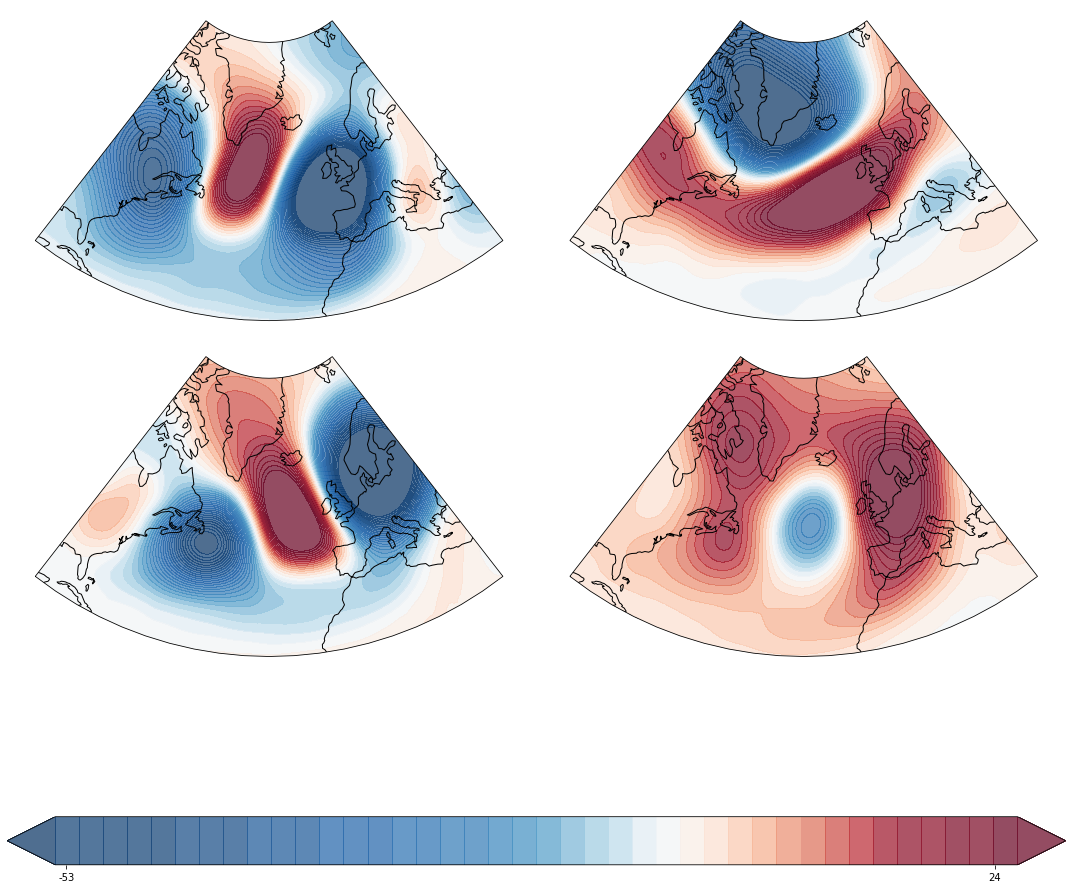

In [19]:
estimator = load_estimator('../models/SUMMER/vae_3months_1normal/kmeans_model_ch.pkl')
labels, inertia, _ = extract_regimes(reduced_anomaly, method='kmeans', nb_regimes = 8, estimator = estimator)
plot_regimes(pivot_anomaly, labels)

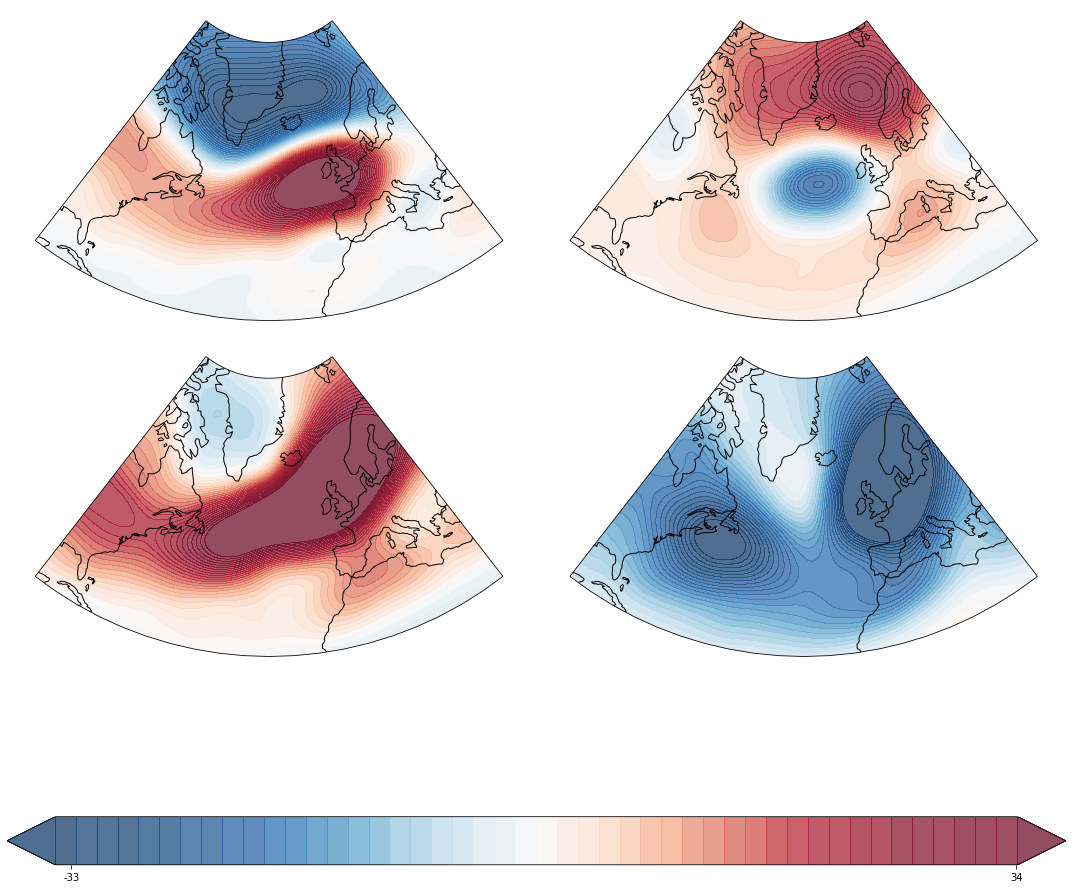

In [20]:
estimator = load_estimator("../models/SUMMER/vae_3months_1normal/gmm_model_bic.pkl")
probas, elbo, means, covariances, _ = extract_regimes(reduced_anomaly, method='gmm', nb_regimes = 5, estimator = estimator)
labels = np.argmax(probas, axis=1)
plot_regimes(pivot_anomaly, labels)

<bound method BaseEstimator.get_params of BayesianGaussianMixture(max_iter=3000, n_components=4, n_init=10,
                        random_state=42, tol=1e-07,
                        weight_concentration_prior_type='dirichlet_distribution')>


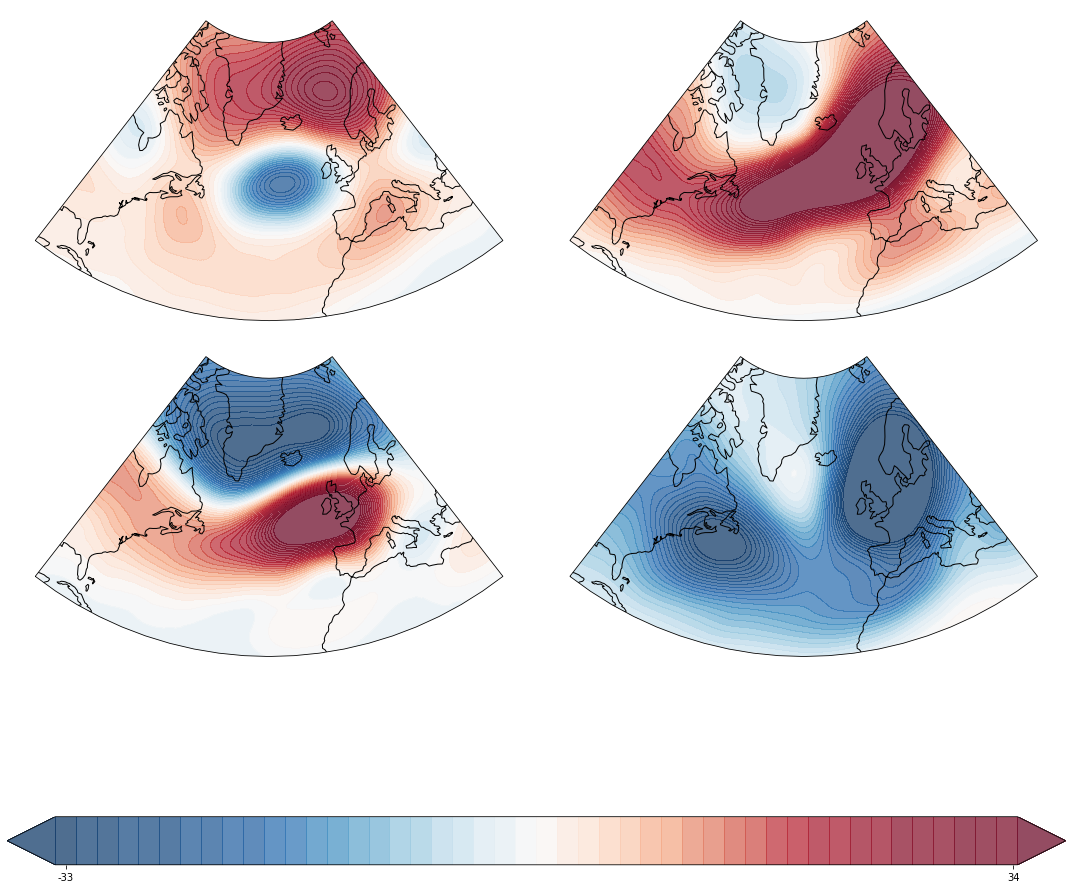

In [24]:
estimator = load_estimator("../models/SUMMER/vae_3months/bayesian_gmm_model_bic.pkl")
probas, elbo, means, covariances, _ = extract_regimes(reduced_anomaly, method='gmm', nb_regimes = 5, estimator = estimator)
labels = np.argmax(probas, axis=1)
plot_regimes(pivot_anomaly, labels)

### PCA: 3 months (June, July, August) and 1 Normal

In [14]:
pd.DataFrame.from_dict({model:performance_matrix('../models/SUMMER/pca_3months_1normal/'+ model, train_X.values, test_X.values)\
                        for model in os.listdir('../models/SUMMER/pca_3months_1normal') if model.endswith('pkl')},
             orient='index')

Number of Clusters            BIC  \
kmeans_model_bic.pkl                          6 -153698.093748   
kmeans_model_ch.pkl                           4 -153883.797348   
kmeans_model_score.pkl                        7 -153718.936694   
kmeans_model_silhouette.pkl                   4 -153883.797360   

                             Silhouette Score  Calinski Harabsz Index  \
kmeans_model_bic.pkl                 0.076885               65.719487   
kmeans_model_ch.pkl                  0.076163               79.936693   
kmeans_model_score.pkl               0.068197               59.138357   
kmeans_model_silhouette.pkl          0.076163               79.936693   

                                  Inertia  
kmeans_model_bic.pkl         1.972255e+11  
kmeans_model_ch.pkl          2.138657e+11  
kmeans_model_score.pkl       1.929927e+11  
kmeans_model_silhouette.pkl  2.138657e+11

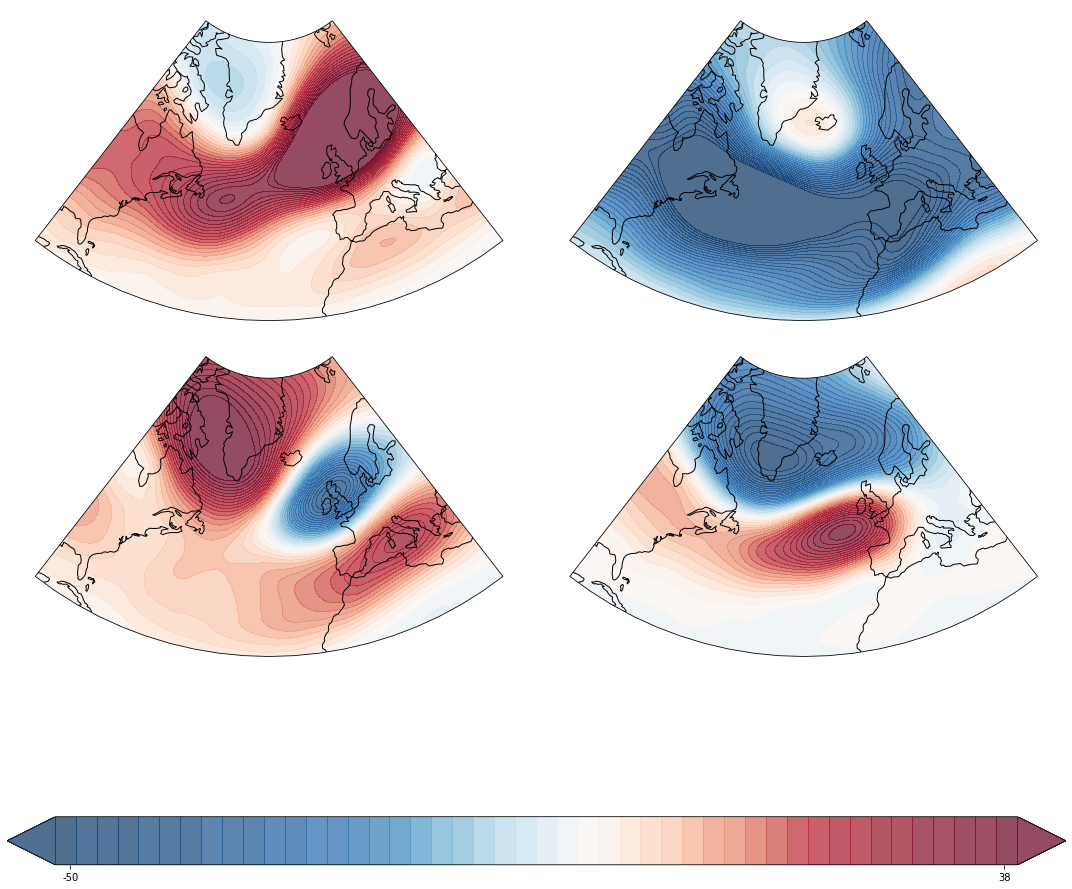

In [18]:
estimator = load_estimator('../models/SUMMER/pca_3months_1normal/kmeans_model_ch.pkl')
labels, inertia, _ = extract_regimes(reduced_anomaly, method='kmeans', nb_regimes = 8, estimator = estimator)
plot_regimes(pivot_anomaly, labels)

## Reporting of results

Number of days: 3956, Density of the grid: 21 cells
	func:'reduce_dim' took: 9.0307 sec


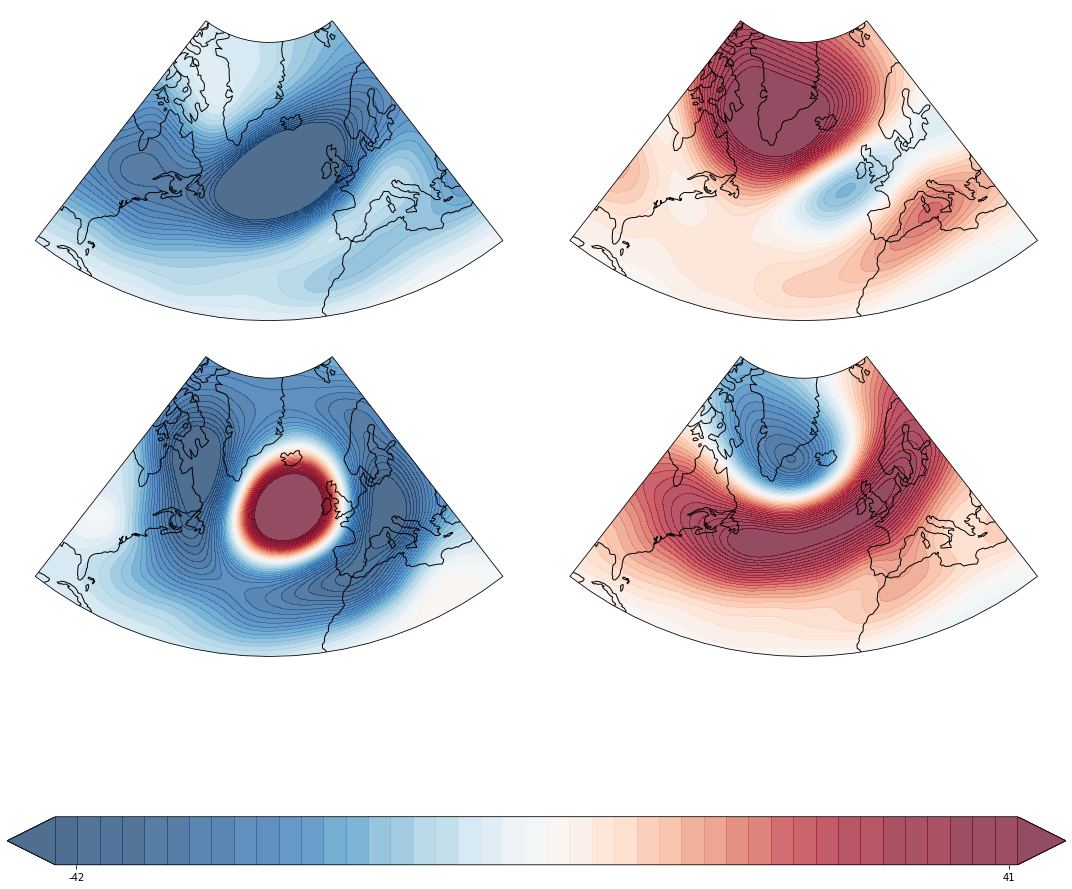

Processing batch 16Number of days: 3956, Density of the grid: 5 cells
	func:'reduce_dim' took: 666.3794 sec


C:\Users\ABALDO\AppData\Roaming\Python\Python36\site-packages\matplotlib\colors.py:1326: RuntimeWarning:

invalid value encountered in log

C:\Users\ABALDO\AppData\Roaming\Python\Python36\site-packages\matplotlib\colors.py:1326: RuntimeWarning:

divide by zero encountered in log

C:\Users\ABALDO\AppData\Roaming\Python\Python36\site-packages\matplotlib\colors.py:1327: RuntimeWarning:

invalid value encountered in multiply



AttributeError: 'NoneType' object has no attribute 'extents'

<Figure size 1080x1080 with 3 Axes>

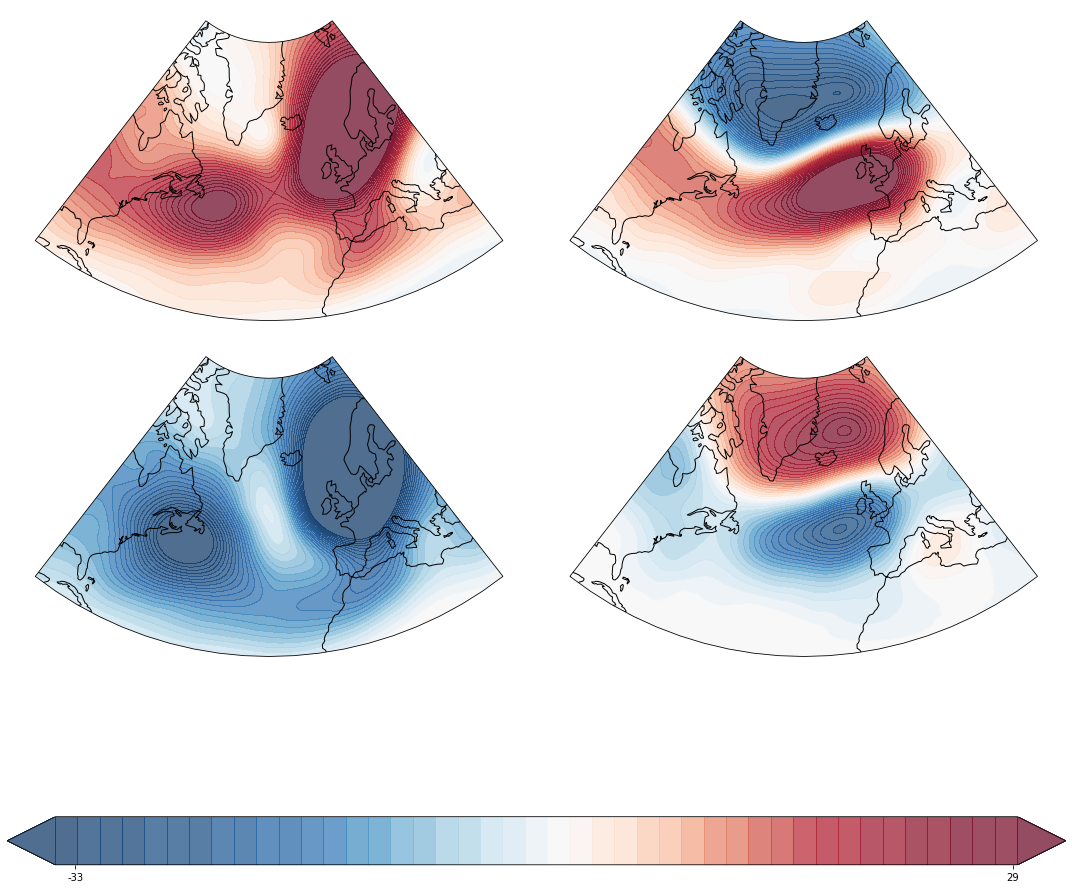

In [25]:
for name, model in zip(['K-Means', 'Bayesian-GMM', 'GMM'],
            ['pca_4months_weeklynormal/kmeans_model_silhouette.pkl',
             'vae_3months_1normal/bayesian_gmm_model_bic.pkl',
             'vae_3months_1normal/gmm_model_ch.pkl']):
    est = load_estimator('../models/SUMMER/'+ model)
    try:
        labels = est.predict(reduced_anomaly.values)
    except:
        if model.startswith('pca'):
            reduced_anomaly = reduce_dim(pivot_anomaly, method='PCA', exp_variance = 21)#exp_variance=0.)
        else:
            reduced_anomaly = reduce_dim(ds, method='VAE', season = 'SUMMER')
        labels = est.predict(reduced_anomaly.values)
        
    plot_regimes(pivot_anomaly, labels)

In [30]:
def plot_regimes2(pivot_dt, labels, **kwargs):
    '''
    Method to plot centroids after applying clustering algorithm
    Args:
    - pivot_dt: an xarray Dataset with size time x (lat_lon)
    - labels: an array containing the labels after the clustering
    - kwargs: additional parameters such as filename for saving the figure
    '''
    xlim, ylim = (pivot_dt['longitude'].values.min(), pivot_dt['longitude'].values.max()), \
                 (pivot_dt['latitude'].values.min(), pivot_dt['latitude'].values.max())
    trans = ccrs.PlateCarree()
    proj = ccrs.LambertConformal((xlim[1] + xlim[0]) / 2, (ylim[1] + ylim[0]) / 2)

    pivot_dt = pivot_dt.unstack('latlon').assign_coords(labels=('time', labels))
    pivot_dt = pivot_dt.groupby('labels').mean()
    vmin, vmax = pivot_dt.quantile(.05).values, pivot_dt.quantile(.95).values
    print(vmin, vmax)
    cset = pivot_dt.plot.contourf(x="longitude", y="latitude", col="labels", levels=50, col_wrap=2,
                                  transform=trans, alpha=.7, cmap="RdBu_r", robust=True,
                                  norm=mpl.colors.SymLogNorm(vmin=vmin, vmax=vmax,
                                                             linthresh=max(pivot_dt.quantile(.85).values, .1), base=10),
                                  subplot_kws=dict(projection=proj), figsize=(15, 15),
                                  cbar_kwargs=dict(
                                      orientation='horizontal' if len(np.unique(labels)) <= 4 else "vertical",
                                      extend='both', ticks=[vmin, vmax], format="%d"))

    for i, ax in enumerate(cset.axes.flat):
        ax.coastlines()
        rect = mpl.path.Path([[xlim[0], ylim[0]],
                              [xlim[1], ylim[0]],
                              [xlim[1], ylim[1]],
                              [xlim[0], ylim[1]],
                              [xlim[0], ylim[0]],
                              ]).interpolated(20)
        proj_to_data = trans._as_mpl_transform(ax) - ax.transData
        rect_in_target = proj_to_data.transform_path(rect)
        ax.set_boundary(rect_in_target)
        ax.set_extent([xlim[0], xlim[1], ylim[0] - 10, ylim[1]])

        # ax.set_title(f"Cluster-{i+1}",y = -0.2 if i>1 else 1)
        ax.set_title("")

    if 'savefig' in kwargs:
        plt.savefig("../imgs/" + kwargs['savefig'])
    plt.show()